# Результат ревью:

Я отмечаю адекватный уровень твоей программистской подготовки. Ты используешь продвинутые концепции языка Python, библиотеки pandas и одной из основных библиотек машинного обучения sckit-learn. Это показывает твой уровень владения инструментами анализа данных и machine learning.

С комментированием никаких проблем нет. Твоих объяснений достаточно для понимания твоими коллегами хода мыслей. Ссылки из брифа проекта в нужных местах также помогают следовать за развитием событий и дают полную информацию касаемо того, что будет происходить в том или ином разделе проекта.

Мне было просто проверять твой проект, потому что он чётко структурирован, с использованием оглавления. 

Зелёным цветом я отметил и прокомментировал удачные и элегантные решения, на которые ты можешь опираться в будущих проектах.

Жёлтым цветом я выделил то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас.

Красных комментариев, которые бы не позволяли мне принять твой проект в его нынешнем состоянии - нет. 

ПРОЕКТ ПРИНЯТ!

Подводя итог: отличная работа, молодец! Желаю тебе успехов в учёбе, желаю, чтобы проекты сдавались или сразу, или после первой итерации! Удачи!

Если же после факта принятия проекта у тебя возникнут дополнительные вопросы – я никуда не пропал. Мой адрес эл/почты: anepomnjashiy@gmail.com, имя в Пачке: anepomnjashiy, имя в Телеграмме: https://t.me/aleks_nep

p.s. я тебе на твой адрес эл/почты сейчас вышлю некоторые материалы из своей электронной библиотеки - надеюсь они будут тебе полезными в учёбе.</div>

Приветствую Геннадий! 

Меня зовут Александр Непомнящий и я буду проверять твой проект. Предлагаю общаться на «ты» :))) Но, если это не удобно - мы вполне можем перейти на вы".

Вкратце обо мне: я работаю в сфере информационных технологий, аналитика (анализ) данных - это и мой рабочий функционал и личная, интересная мне область для саморазвития. Используемый стек: python, pandas, графические библиотеки matplotlib/seaborn/plotly. Сфера применения: маркетинговая аналитика в медицинской клинике. Если вдруг есть вопрос – что делает аналитик в коммерческой медицине – то вот короткий ответ. Самый главный вопрос, на который мы хотим получить ответ (и который в дальнейшем приведёт к перераспределению рекламного бюджета, плюс напрямую повлияет на разработку и предложению рынку новых лечебных программ) - это КТО ОН, НАШ КЛИЕНТ? Фактически это задача (на нашем внутреннем языке формулируется как построение и анализ «ПОРТРЕТА КЛИЕНТА»). Визуализируем и пытаемся придать смысл половозрастным данным наших клиентов, кто из какого региона и в какие времена года к нам приезжает. Учитываем количество приездов. Учитываем на какую программу этот конкретный клиент приехал в первый раз и как в дальнейшем меняются его предпочтения. Пытаемся построить модель оттока и спрогнозировать, когда клиент уйдёт в отток. Смотрим цифры (суммы трат клиентов на отдельных группах медицинских программ). Анализируем медицинские услуги, которые входят в путёвку, а также что, в каких количествах и на какую сумму клиент покупает дополнительно. Очень вкратце как-то так.

Теперь к сути: основная цель моей проверки - пройти по шагам, по логике твоего решения и обсудить те моменты, которые можно изменить, улучшить, довести до идеала. Такой формат работы двух программистов (аналитиков) ты или уже встречал(а), или встретишь на своей новой работе. Кто-то такой процесс называет "код-ревью", ну а как по мне, так это обмен опытом двух коллег, когда каждый из нас становиться лучше в процессе дискуссии.

Свои мысли, советы, комментарии и вопросы я буду оставлять в текстовых ячейках (markdown) ПОД твоим кодом. 
Для твоего удобства все эти заметки будут "цветными", как на примерах ниже:

"Зелеными" комментариями я буду отмечать твой элегантный ("красивый") код и/или удачные решения, на которые ты можешь смело опираться в будущих проектах.
<div class="alert alert-success">
<b>Отлично! 👍</b>

Отличная находка, элегантный код ...</div>

"Жёлтые" комментарии - это мои размышления, предложения, что-то, что на следующей итерации можно сделать по-другому. Твоя реакция на "жёлтые" комментарий необходима и подразумевает или правки, или реакцию или аргументированное согласие/не согласие. Я искренне верю, что наш двусторонний диалог под "желтым" комментарием - это то, от чего твой проект только выиграет. <div class="alert alert-warning">
<b>Комментарий 👉</b>

Здесь я бы предложил использовать .... Мои аргументы в пользу этого ...</div>

"Красные" комментарий будут появляться, когда что-то пойдёт не так: например, код будет выдавать ошибку. Или, когда в проекте не будет ответов на основные вопросы, ради которых весь анализ и выполнялся. "Красные" комментарии необходимо будет исправить, прежде чем я смогу принять проект.
<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

В этой ячейке код работает не так как задумано ...</div>

Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Это поможет мне оперативно выполнить повторную проверку твоего проекта.

Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом, лучше всего в новой ячейке, сразу под моим комментарием. Если для своих комментариев ты будешь использовать какой-то заметный цвет, то мне будет легче отследить твои изменения, например так:
<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Текст твоего комментария ...</font>
</div>

**Распространенные типичные недочёты в проектах студентов:**

<div class="alert alert-danger" ❌>
Неработоспособный код. Проверь проект на работоспособность перед отправкой на проверку. Это важный навык, который тебе пригодится как на собеседовании, при выполнении тестового задания, так и перед совещанием у руководства компании.</div>
<div class="alert alert-danger" ❌>
Проект не структурирован. В проекте должна быть структура, т.е. названия разделов и подразделов должны быть записаны в ячейках Markdown.</div>
<div class="alert alert-warning" 👉 >
Отсутствие описания, целей проекта, его задач, выводов. В описании должны быть озвучены поставленные задачи, содержание датасета, промежуточные и финальные выводы. Как правило, заказчик читает только финальный вывод, поэтому важно добавить информацию о проведенном исследовании, применить форматирование текста, в общем, сделать красиво, чтобы было понятно, что проведено настоящее исследование и выводу можно верить.</div>  
<div class="alert alert-warning" 👉 >
"Длинный код". Код и и комментарии, которые прячутся за правым концом ячейки нужно переносить на новую строку. Твои будущие коллеги не оценят необходимость постоянного скроллинга. Согласно PEP8: https://www.python.org/dev/peps/pep-0008/ длина строки не должна превышать 79 символов.</div>
<div class="alert alert-warning" 👉 >
Твои коллеги ценят и твое и своё время, поэтому "подсвечивай" свои комментарии в ячейках Markdown. Подробнее про синтаксис Markdown, с примерами, можно почитать здесь: https://paulradzkov.com/2014/markdown_cheatsheet/?
</div>

# Проект: Обучение с учителем: качество модели "в один клик"

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

### Цель исследования

Провести анализ данных при помощи которых предприятие разработает стратегию взаимодействия с клиентами

### Основные задачи исследования

Нам потребуется предобработать данные, провести базовый исследовательский анализ и обучить модель для предсказания поведения покупателя

### Исходные данные

Нам даны три таблицы: первая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении, вторая содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом, третья содержит данные о среднемесячной прибыли продавца за последние 3 месяца, то есть какую прибыль получает магазин от продаж каждому покупателю.

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Да, это это калька из брифа проекта и здесь, в учебной задаче это ОК, но "в жизни" я бы рекомендовал тратить чуть больше времени и усилий на подготовку более полного "Введения". Т.е. подробнее описать суть проекта, цели и задачи, способы решения. Небольшая вводная перед исследованием даст коллегам понимание о том, чему оно посвящено и как будет реализовываться.

Примерное оформление и наполнение "Введения" таково (это исключительно мой вариант, который бы я рекомендовал к использованию):
    
____    
    
**Название проекта**
_____
**Описание исследования.**
    
_____
**Цель исследования.**
    
Суть исследования. Например: 

Провести анализ данных при помощи которых предприятие разработает стратегию взаимодействия с клиентами.
    
_____
**Задачи исследования.**

Действия, необходимые для достижения поставленной цели.
_____
**Исходные данные.**
    
Здесь описываешь исходные таблицы.
______

**Данное исследование разделим на несколько частей.**

***Часть 1. Изучение общей информации:***
* [1. Изученеие файлов с данными, получение общей информации, загрузка библиотек.](#1-bullet)
* [2. Нахождение и ликвидация пропусков.](#2-bullet)

***Часть 2. Подготовка данных:***
* [1. Приведение данных к нужным типам.](#3-bullet)
* [2. Нахождение и исправление аномалий и ошибок.](#4-bullet)

и т.д

Старайся выполнять свой проект в порядке, прописанном в твоем плане. Да, такое оформление займет больше времени, но затем позволит быстро и последовательно идти по шагам выполнения.
_________________

Обрати внимание, что пункты в частях у меня в виде ссылок. Это очень удобно, когда нужно переходить по разным частям проекта.
Вот тут почитай, как сделать <a href="https://sebastianraschka.com/Articles/2014_ipython_internal_links.html">кликабельные разделы</a>. Кликабельность сама по себе не обязательна, но план и цели, хотя бы кратко всегда прописывать желательно.

**Почему это важно?** Когда ты будешь в будущем выполнять тестовые задания, просто скопировав присланную тебе задачу и не составив плана, ты можешь этим смутить своего будущего работодателя. А чётко структурированный план покажет тебя как логично и системно думающего аналитика. Также такой подход научит тебя структурировать исследование и не путаться при работе с большими проектами.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Описание проекта чутка подправил, сейчас времени мало, скоро уже жесткий дедлайн, но в будущем кликабельность разделов обязательно внедрю, спасибо за ссылку на материал для обучения</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Геннадий - приветствую! Приступаю ко 2ой итерации проверки и если всё исправлено, то сразу приму твой проект!
</div>

# Шаг 1. Загрузка данных

Начинаем проект с того, что подключаем нужные нам библиотеки

In [1]:
!pip install shap -q

In [2]:
!pip install phik -q

In [3]:
!pip install scikit-learn==1.1.3 -q

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Полезный ключ **-q** (он "подавит" служебные сообщения об установке, которых может быть достаточно много - вплоть до нескольких экранов прокрутки).
</div>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats

from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from statistics import stdev

from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

from sklearn.metrics import f1_score, precision_score, roc_auc_score, make_scorer


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, все импорты собраны в начале "тетрадки"!

---
В Python есть своя философия. Именно отсюда берутся определенные правила и стандарты. В пайтон такое соглашение назвали PEP8.

Соответствие PEP8 позволяет видеть основную структуру вашего кода другим разработчикам. Не нужно привыкать к другому оформлению кода. Если вы привыкли как-то оформлять код, а увидели что-то совершенно другое, то вы поймете. 

Официальная документация: https://peps.python.org/pep-0008/ 

Основные моменты и рекомендации:

- Используй пробелы, разрешается использование табов, но смешивание запрещено. Отступ соответствует 4 пробелам. Хорошие редакторы кода автоматически заменяют табы на пробелы.

- Вокруг операторов +, -, =, *, /, ** должны быть пробелы. 

- Строка не должна превышать 79 символов

- Ну и наконец про импорты: импорты можно делать только по одному на строку! При этом из одного модуля можно доставать несколько нужных объектов. Порядок тоже важен:

- импорты из стандартной библиотеки
- импорты из сторонних библиотек
- импорты пользовательских модулей текущего проекта (например если выносишь функции в отдельный модуль)

И нежелательно их перемешивать с константами и переменными.

p.s. состав стандартных библиотек Python здесь: [The Python Standard Library](https://docs.python.org/3/library/)
</div>

Теперь пора считать данные

In [5]:
df_main = pd.read_csv('/datasets/market_file.csv')
df_market_money = pd.read_csv('/datasets/market_money.csv')
df_time = pd.read_csv('/datasets/market_time.csv')
df_money = pd.read_csv('/datasets/money.csv',sep=';')

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично. Импортировали требуемые для анализа библиотеки и загрузили данные. Сейчас посмотрим на их состояние и если всё ОК, сможем приступать к построению моделей....

p.s. при установке дополнительных библиотек (через ! pip install ...) можно использовать полезный ключ **-q** (он "подавит" служебные сообщения об установке, которых может быть достаточно много - вплоть до нескольких экранов прокрутки)

p.p.s. При считывании данных из файла здорово перестраховывать себя от ошибок, связанных, например, с неверным указанием пути к файлу. А иногда бывает, что работаешь с файлом локально, выгружаешь его на сервер, ожидая, что он будет принимать данные, которые лежат на том же сервере, а код падает с ошибкой, потому что путь к файлу не поменялся с локального на серверный.
    
Для этого, например, можно использовать конструкцию `try-except`: сначала пробуешь локальный путь, при возникновении ошибки используется серверный путь (подробнее можешь почитать тут: https://pythonworld.ru/tipy-dannyx-v-python/isklyucheniya-v-python-konstrukciya-try-except-dlya-obrabotki-isklyuchenij.html).
    
Но еще лучше использовать библиотеку `os` - её использование позволит тебе проверять существование указанных директорий (что может быть актуально при одновременной работа на локальном и сетевом окружении) и загружать данные из существующей директории, избегая ошибок. Как пример:
    
    import os

    pth1 = '/folder_1/data.csv'
    pth2 = '/folder_2/data.csv'
    
    if os.path.exists(pth1):
        query_1 = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        query_1 = pd.read_csv(pth2)
    else:
        print('Something is wrong')

Ещё на этапе считывания данных можно спарсить дату: за это действие отвечает параметр `parse_dates` метода `read_csv()`, в него нужно передать список с названием полей-дат, и в большинстве случаев дата будет корректно преобразована в нужный формат сразу:)
Также на этапе считывания данных задать индекс-столбец- за это действие отвечает параметр `index_col`.
</div>

Ознакомиммся с данными

In [6]:
display(df_main.head(5))
display(df_market_money.head(5))
display(df_time.head(5))
display(df_money.head(5))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Данные корректно считались и соответствуют описанию

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Хорошо, данные загрузили, первичные проверки сделали.
</div>

# Шаг 2. Предобработка данных

Базово изучим датафреймы

In [7]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

<div class="alert alert-warning">
<b>Комментарий 👉</b>

В наших данных пропусков НЕТ, НО ЕСЛИ БЫ БЫЛИ .... я стараюсь дать подробный коммент-видение на тему обработки пропусков данных (так как понимаю, что несмотря на кажущуюся простоту - не очень просто понять чем ("заглушкой"? / медианой? / средним? / по комбинации столбцов?) заполнять? а может удалять?      

---    
По результатам проверки 5+ тысяч проектов за 3 года у меня родилось небольшое эссе на тему "удаления vs. спасения" данных, как раз на основе тех ситуаций и вопросов, которые мне коллеги задавали, которые мы обсуждали, уточняли и исправляли ... 

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>Подробнее ...</u></summary>

Желание уменьшить количество пропусков в данных (если такое желание конечно возникает ... но в рабочих проектах, "в жизни" оно как правило возникает) - можно только приветствовать. Приветствовать по 3-м минимум причинам:

1. это тренировка
    
2. это попытка сохранить данные ("данных много не бывает")
    
3. самое главное на мой взгляд - развитие аналитического мышления, желания "проникать" в секреты, которые скрывают данные. Когда вначале рождается гипотеза, потом эта гипотеза проверяется на данных (может ли такое быть? подтверждается?) и в финале уже гипотеза облекается в код.

Однако заполнение пропусков в данных не такая простая задача, как кажется ... простого ответа на вопросы: заполнять? удалить? чем заполнять? подходящего под все сценарии, нет ни в одной умной книжке ...

Самый идеальный случай - когда у тебя под рукой есть эксперт в предметной области. Если такой есть - советуйся с ним. Как правило это человек из бизнеса, который знает суть бизнес-процесса и вот именно он даст тебе точный и аргументированный совет - что в данной, конкретной задаче делать с "битыми" полями в строках датафрейма. Ты скажешь ему какой процент пропусков в данных, а он тебе ответит что делать: можно/нельзя удалить и/или даст рекомендации по заполнению. Вообще, как правило такой человек "на любой работе" есть. Для примера, финансовый директор думаю всегда даст рекомендации по финансовым данным, прочие профильные спецы - по своей сфере компетенций. Наверное только в зарождающемся стартапе может не быть каких-то компетенций, но тут уже можно и через фриланс (и т.п.) попробовать найти спеца и просить совета.

Теперь, что делать, если такого человека нет. Я бы ответил так: **ПОПЫТАТЬСЯ** вникнуть в бизнес-проблему самому. Наверное это сложно, если предметная область ну совсем незнакома. Но в общем случае, если бизнес совсем незнаком, то заполнение пропусков в данных наверное, не получиться. В таком случае попробуй ориентироваться на такое правило: если записи с пропусками в ключевых для твоего анализа столбцах составляют 1-3-5-ну может до 10% строк, то попробуй эти записи из оригинального датафрейма вырезать (но сохрани бы в некий df, к которому ты при необходимости можешь всегда обратиться).

В жизни, МНЕ КАЖЕТСЯ, как правило по всему датафрейму заполнять медианой/средним - ну вообще не вариант. Почему? Я бы ответил так - потому, что реальные датафреймы имеют миллионы строк и горизонт в несколько (десятков) лет, и если в 90-2000-е года всё было как-то более -менее стабильно/прогнозируемо, то в нынешней реальности события раскручиваются гораздо быстрее и не прогнозируемо. Пример: ты аналитик в автобизнесе. У тебя есть данные с пропусками в цене для машин в 2005-2007 года. Можно заполнить их средними основываясь на данных 2020-2021?

Может быть и такой вариант, что без заполнения некоторых столбцов некоторые записи по сути **НЕ** имеют смысла, но если их (записи с пропусками удалить), то и данных-то не останется. Ну тогда я бы такой совет дал - всё же заполнять медианой (она к скачкам выбросов более устойчива), но не по всему глобальному датафрейму, а выбрать простые группы (например, группы по интервалу лет - чтобы сгладить турбулентность нынешних лет) или выбрать более сложные группы (например, группы по интервалу лет и одновременно марке автопроизводителя (это я про вымышленный пример с автобизнесом)).

Теперь предположим, что мы выбрали какую-то стратегию заполнения "пропусков", не суть какую (оставить NaN или заполнить "заглушкой"). И в том и в другом случае придётся помнить этот выбор. Ты спросишь почему? Отвечу - потому, что инструменты, применяемые тобой в Питон/Пандас в каких-то случаях могут спокойно пропускать твой выбор, а в каких-то случаях тебе придется этот твой выбор обрабатывать.

Пример 1: мы заполнили пропуски "заглушкой". В этом случае: 1. расчет корреляций значение "заглушку" будет "ловить" (надо отфильтровать!), 2. расчет гипотез также будет "сбивать" правильный вывод (надо отфильтровать!) 3. графики, которые ты будешь строить - будут "заглушку" отображать на осях (нужно фильтровать), 4. в группировках также по-видимому "заглушку" надо будет убирать.

Пример 2: мы оставили пропуски как NaN. В этом случае: 1. метод .corr NaN'ы пропускает (отфильтровать не надо), 2. в расчет гипотез всё равно пропуски отфильтровать 3. графики, которые ты будешь строить могут отображать, а могут не отображать, 4. в группировках NaN'ы по sum() видны не будут, а по count() будут.

Ну и напоследок совсем уже жёсткий пример: додумывать "от себя", бездумно проставлять в пропуски медианные/средние значения - это НЕ верно. Давай же опять "про жизнь". Я писал выше, что в медицине работаю, да? **Предположим** мне принесли данные из онкологического диспансера. Задача: построить модель, которая по некоторым маркерным анализам будет прогнозировать наличие онкологии. **По-простому, ответить, что стоит за строчкой в данных: жизнь или смерть.** Уууууух … аж мороз по коже продирает, правда? 

Итак, 1.000.000 записей и 70 столбцов. Данные за 25 лет. 70 столбцов - это поля, с результатами конкретных и очень специфичных анализов. В "начале" данных, 15-20 лет назад, есть пропуски (много), но и в принципе, в данных есть пропуски. Как думаешь - имею я моральное право перед людьми, которые фактически доверяют мне в виде данных свою жизнь огульно подойти к заполнению пропусков?

</details>
<br>
<br>
</div>


In [8]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


По типам данных почти все хорошо столбец с прибылью в четвертой таблице надо перевести в float

In [11]:
df_money['Прибыль'] = df_money['Прибыль'].str.replace(',','.')
df_money['Прибыль'] = df_money['Прибыль'].astype('float')
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, привели типы ... явно числовые типы, но при этом имеющие тип "строка" приведены к числовому типу.

---
Кроме того, что теперь признаки в нашем датафрейме имеют корректные типы данных - это действие ещё и вот по какой прчине полезно: оптимизация объёма больших датасетов может помочь значительно сократить объём памяти (занимаемый датасетом). Это особенно важно, если у нас ограничены вычислительные ресурсы или требуется работать с огромными объёмами данных.

Функция pd.to_numeric() с параметром downcast='integer' позволяет снизить тип числовых данных до наименьшего возможного размера без потери информации. Например, преобразование целочисленных значений из типа int64 до int32, int16 или int8 может существенно сократить использование памяти, особенно если значения в датасете могут быть представлены более короткими типами данных.

Однако при использовании этой оптимизации следует быть осторожным. Преобразование типов данных может привести к потере точности или диапазона значений, особенно если числа в датасете имеют большой разброс или могут выходить за пределы нового типа данных. Поэтому перед использованием функции pd.to_numeric() с параметром downcast='integer', рекомендуется проверить, что сокращение размера типа не приведет к потере важной информации для конкретной задачи.
</div>

Посмотрим как обстоят дела с пропусками

In [12]:
print(df_main.isna().sum())
print()
print(df_market_money.isna().sum())
print()
print(df_time.isna().sum())
print()
print(df_money.isna().sum())

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

id         0
Период     0
Выручка    0
dtype: int64

id        0
Период    0
минут     0
dtype: int64

id         0
Прибыль    0
dtype: int64


<div class="alert alert-warning">
<b>Комментарий 👉</b>

По результатам info() выше уже было видно что пропусков в данных нет. В принципе эту проверку можно было бы и не делать, она избыточной кажется.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Я могу объясниться, мне кажется для визуализации так будет понятнее, намного проще когда есть надпись "проверка на пропуски" и дальше везде нолики напротив признаков, чем в .info, где вначале идет сколько всего элементов, потом напротив каждого признака сколько там ненулевых объектов и там еще рядом куча другой информации написана помимо пропусков, поэтому думаю лучше оставить как есть</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Да, давай оставим, тем более что это не ошибка, а всего лишь желтый комментарий меня, как твоего коллеги.
</div>

Пропусков не наблюдается, тогда переходим к проверке на дубликаты и неявные дубликаты

In [13]:
print(df_main.duplicated().sum())
print()
print(df_market_money.duplicated().sum())
print()
print(df_time.duplicated().sum())
print()
print(df_money.duplicated().sum())

0

0

0

0


<div class="alert alert-warning">
<b>Комментарий 👉</b>

Хочу отметить, что в общем случае, "в жизни", даже если **df.duplicated().sum() == 0** - это может совсем не означать, что в данных нет дубликатов. 
    
---
В реальных рабочих датасетах скорее всего не будет полных дубликатов, но вот неявные наверняка будут встречаться, соответственно с ними надо будет уметь работать. Для поиска неявных дублей обычно используют параметр **subset** у функции duplicated(). Правда здесь, в нашем проекте, надо поразмыслить над тем какие комбинации столбцов могут говорить о реальных дублях в данных.</div>

Явных дубликатов не нашлось, проверим наличие неявных, начнем с первой таблицы

In [14]:
print(df_main['Покупательская активность'].value_counts())
print()
print(df_main['Тип сервиса'].value_counts())
print()
print(df_main['Разрешить сообщать'].value_counts())
print()
print(df_main['Популярная_категория'].value_counts())
print()

Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

да     962
нет    338
Name: Разрешить сообщать, dtype: int64

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64



пупупу в столбце с типом сервиса есть неявный дубликат, сейчас все поправим

In [15]:
df_main['Тип сервиса'] = df_main['Тип сервиса'].str.replace('стандартт','стандарт')

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, первый баг в данных обнаружен. Есть ещё два ....
</div>

Теперь проверим вторую и третью таблице

In [16]:
print(df_time['Период'].value_counts())
print()
print(df_market_money['Период'].value_counts())

предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

препредыдущий_месяц    1300
предыдущий_месяц       1300
текущий_месяц          1300
Name: Период, dtype: int64


Есть несоответствие в названии одного из значений столбца с периодом в таблице со временем

In [17]:
df_time['Период'] = df_time['Период'].str.replace('предыдцщий_месяц','предыдущий_месяц')

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Баг в данных не найден (сравни названия):
    
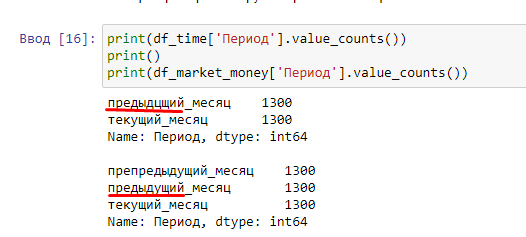    
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Исправил. Тут я тоже могу объясниться) на самом деле это не отменяет того, что можно было бы исправить этот момент, но я что-то про него забыл и решил не исправлять так как при объединении мы все равно переносим все в одну таблицу и эта ошибка в названии исправится автоматически</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
    
p.s. лучше ошибки в данных "за спиной не оставлять" (в надежде что исправиться само).
    
p.p.s. **так как при объединении мы все равно переносим все в одну таблицу и эта ошибка в названии исправится автоматически** - я вот не уверен что исправиться всё автоматом.
</div>

По итогу предобработки данных было проверено наличие пропусков(не нашлись), наличие явных дубликатов(не нашлись), в столбце с типом сервиса из первой таблицы было найдено некоторые количество неявных дубликатов, столбец с прибылью в последней таблице был в некорректном формате.

# Шаг 3. Исследовательский анализ данных

Исследовательский анализ данных мы будем делать поэтапно, начиная с первой таблицы, для нее мы построим диаграммы размаха, выкинем все выбросы в количественных признаках, построим для них же гистограммы и построим распределения для категориальных признаков.

Разобьем признаки на количественные и категориальные

In [18]:
df_main_num_col = ['Маркет_актив_6_мес',
                  'Маркет_актив_тек_мес',
                  'Длительность',
                  'Акционные_покупки',
                  'Средний_просмотр_категорий_за_визит',
                  'Неоплаченные_продукты_штук_квартал',
                  'Ошибка_сервиса',
                  'Страниц_за_визит']

df_main_cat_col = ['Покупательская активность',
                  'Тип сервиса',
                  'Разрешить сообщать',
                  'Популярная_категория']

Теперь для количественных признаков построим диаграммы размаха

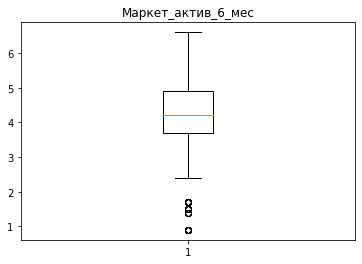

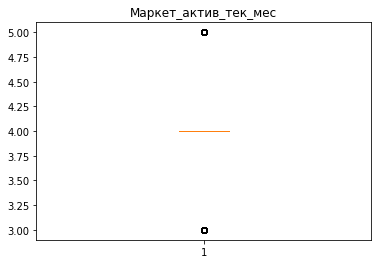

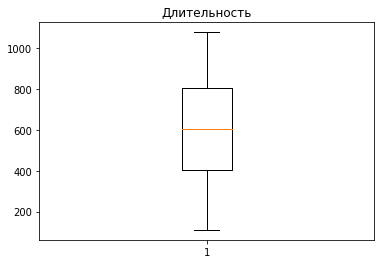

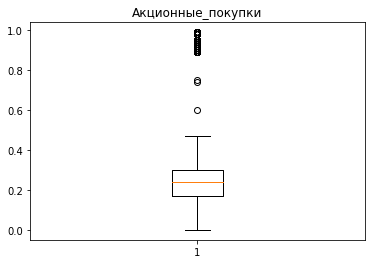

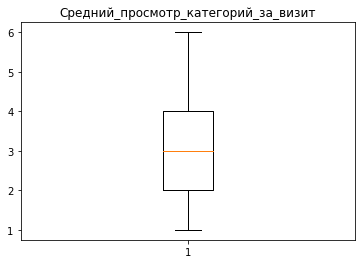

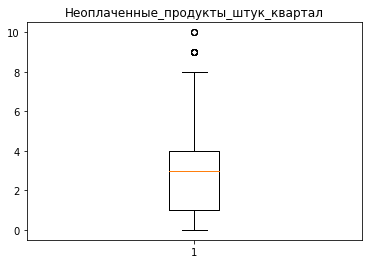

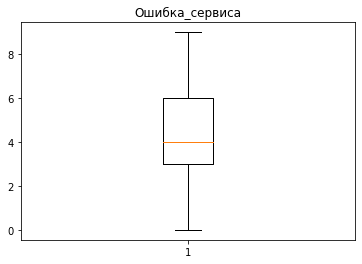

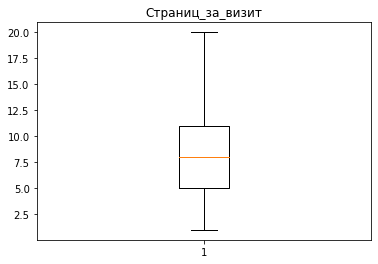

In [19]:
for column in df_main_num_col:
    plt.title(column)
    plt.boxplot(df_main[column])
    plt.show()

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично!  Боксплот рядом с гистограммой - это отлично! Гистограмма будет показывать нам распределение количественного признака, а боксплот даст информацию о **возможных выбросах** (пишу **возможных**, потому что нужно анализировать бизнесовый смысл значений показанных как выбросы ... просто так удалять то, что показывает боксплот за пределами 1,5 IQR от границ "ящика" - неверно) и основных статистиках (квартилях) признака.

p.s. Для дискретных признаков "ящики с усами" не нужны, так как эти признаки имеют скорее распределение категориального признака, пусть и представленного в численном виде.

</div>


<div class="alert alert-warning">
<b>Комментарий 👉</b>

Это не выбросы, это реальные данные реальных покупателей.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Согласен, в данной ситуации лучше подойдет термин аномалия  ...</font>
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

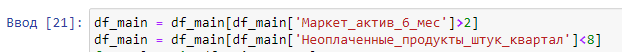   
    
А что, так в жизни быть не может?    
    
---    
Нет, не согласен. Тебе для анализа дали **реальные данные реальной активности реальных покупателей**. Ты "пригладил эти данные горячим утюгом", сделал из реальных - некую "среднюю картину". После того как твоя модель пойдёт в продакшн - она будет плохо работать на реальных данных.
   
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Соглашусь, но хочу узнать кое что. Дествительно, модель будет хуже себя чувстовать на реальных данных, если ее будут обучать на "прилизанных", но можно ли все-так вычеркивать такие данные изолированно для построения тех же гистограмм для оценки общего распределения признаков, например если у меня пик на маленьких значениях и есть какое то количество аномалий на больших значениях. Это некоторое количество больших значений уменьшает масштаб и мешает ознакомиться с основным костяком данных. В такой ситуации разве нельзя чисто для гистограмм убрать такие значения? Просто от меня ревьюеры на предыдущих проектах всегда требовали, чтобы я удалял выбивающиеся за нормаль данные.</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

**но можно ли все-так вычеркивать такие данные изолированно для построения тех же гистограмм для оценки общего распределения признаков, например если у меня пик на маленьких значениях и есть какое то количество аномалий на больших значениях** - смысл этого действия для меня непонятен. Мы хотим построить графики для чего? Для того, чтобы понять как данные в каждом признаке распределены реально, ведь так? Удалили "крайние" значения и что? Посмотрели как данные МОГЛИ БЫ ВЫГЛЯДЕТЬ в некоем идеальном случае. Ну ОК, посмотрели ... и что нам эта идеальная картинка даёт?
</div>

Построим гистограммы для количественных признаков, а также проведем статистический тест на схожесть с нормальным распределением, начнем с непрерывных признаков

Распределение непрерывных количественных признаков


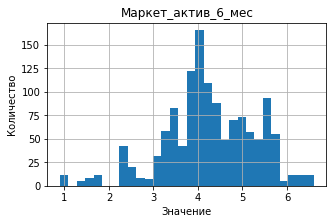

Нулевая гипотеза не подтвердилась


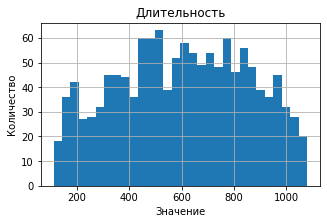

Нулевая гипотеза не подтвердилась


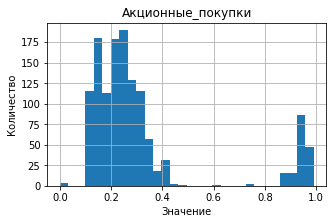

Нулевая гипотеза не подтвердилась


In [20]:
df_main_interval_cols = ['Маркет_актив_6_мес',
                         'Длительность', 
                         'Акционные_покупки']

print('Распределение непрерывных количественных признаков')
for column in df_main_interval_cols:
    df_main[column].hist(figsize=(5,3),bins=30)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();
    if stats.kstest(df_main[column], 'norm', args=(df_main[column].mean(),stdev(df_main[column])), alternative='two-sided').pvalue>0.05:
        print('распределение нормальное')
    else:
        print('Нулевая гипотеза не подтвердилась')

p-value меньше 0,05 у всех построенных распределений, следовательно мы не можем отнести их к нормальному распределению, хотя визульная схожесть есть у всех кроме акционных покупок, все равно нельзя утверждать принадлежность распределений признаков к нормальному распределению

Теперь настала очередь дискретных

Распределение дискретных количественных признаков


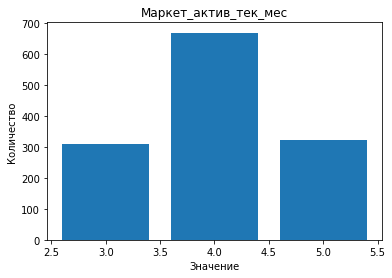

Нулевая гипотеза не подтвердилась


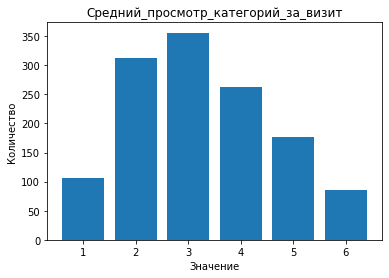

Нулевая гипотеза не подтвердилась


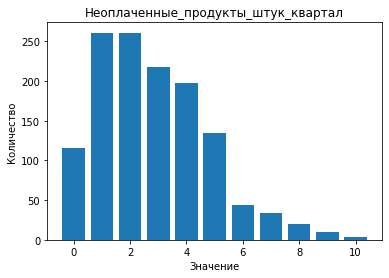

Нулевая гипотеза не подтвердилась


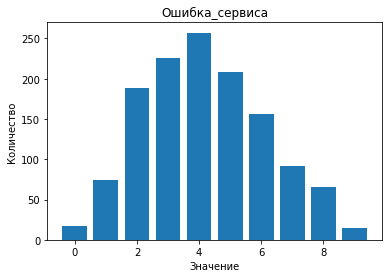

Нулевая гипотеза не подтвердилась


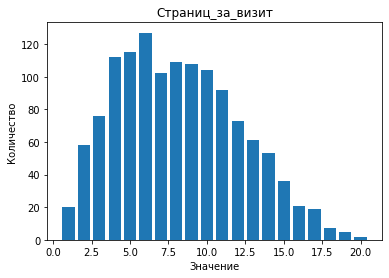

Нулевая гипотеза не подтвердилась


In [21]:
df_main_diskret_cols = ['Маркет_актив_тек_мес',
                        'Средний_просмотр_категорий_за_визит',
                        'Неоплаченные_продукты_штук_квартал',
                        'Ошибка_сервиса',
                        'Страниц_за_визит']

n = {'Маркет_актив_тек_мес':3,
     'Средний_просмотр_категорий_за_визит':6,
     'Неоплаченные_продукты_штук_квартал':10,
     'Ошибка_сервиса':9,
     'Страниц_за_визит':20}

print('Распределение дискретных количественных признаков')
for column in df_main_diskret_cols:
    plt.bar(df_main[column].value_counts().index, df_main[column].value_counts().values)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();
    if stats.kstest(df_main[column], 'norm', args=(df_main[column].mean(),stdev(df_main[column])), alternative='two-sided',N=n[column]).pvalue>0.05:
        print('распределение нормальное')
    else:
        print('Нулевая гипотеза не подтвердилась')

Идентичная ситуация, статистический тест утверждает, что мы не можем отнести эти распределения к нормальным, но все равно визуальная схожесть присутствует

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Пожалуйста "доведи" график(и), так, чтобы эта похвала ниже стала заслуженной ))))   
    
---    
**Просто супер: график подписан, оси подписаны (проверь - так ли это в твоем случае?)**. Не часто на самом деле такой скрупулёзный подход к оформлению встречается. Молодец! Также, здорово, что есть объяснение поведения данного графика. Пытаться понять полученный результат - важная часть работы аналитика.

Я закончил физико-математический факультет Петрозаводского государственного университета. Нас там с первого курса приучили - если на сдачу лабораторной работы по физике приходишь с графиком, на котором не подписано общее название, названия осей (с единицами измерений), единичная шкала - всё сдача заканчивается не начавшись. Или если у моей лабораторной работы отсутствует вывод: что делали? по какой методике? что "намеряли"? как интерпретировали? какой финальный вывод? - всё, тоже на выход. Ну и в принципе сейчас, на текущей работе: код, который написан в тетрадке мало кому понятен и не сильно кому интересен. Важнее детальные выводы и тренды, которые попадут на слайд презентации в PowerPoint. Именно поэтому столь важное значение в аналитике данных придается промежуточным выводам и уж тем более финальному. 

---
(МЕТОДИЧЕСКИЕ МАТЕРИАЛЫ ПО ОФОРМЛЕНИЮ ГРАФИКОВ):

При работе с графиками важно соблюдать следующие правила:

1. Стоит подписать названия осей X и Y.

2. Также стоит дать название графику.

3. Технические комментарии типа `<AxesSubplot:xlabel='datetime'>` стоит убирать - это можно сделать, поставив точку с запятой в последней строке кода в блоке визуализации, либо сделать последней строкой кода этого блока метод plt.show().

4. Графики нужно сделать больше - графики дефолтного размера не очень удобны для чтения. Удобнее будет настроить параметр plt.rcParams["figure.figsize"] = (x,y) сразу в ячейке импорта библиотек, и все графики проекта будут одного размера.
        
Несколько таких нехитрых приёмов повысят качество твоих визуализаций в проекте.
        
Убедись, пожалуйста, что графики проекте соответствуют этим правилам.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поправил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Хотя на графиках подписи теперь есть, но я всё-таки хочу обратить твое внимание, что одинаковые "обезличенные" подписи на всех графиках - это не ОК. Графики принято подписывать так, чтобы подписи **отражали суть** изображенного на осях, а также подписи должны содержать и единицы измерения того, что на осях изображено.

Если графики строяться в цикле, то выход такой: вручную создать словарь: "ключ" - название признака по которому на соответствующем шаге будет строиться график, "значения" - список названий ([название графика, название оси ОХ, название оси ОУ]). Далее пробегаем в цикле по названиям признаков (в данных). Сопоставляем название признака с ключом словаря, а названия подписей (графика и 2х осей) берем из соответствующего этому ключу значения.

</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

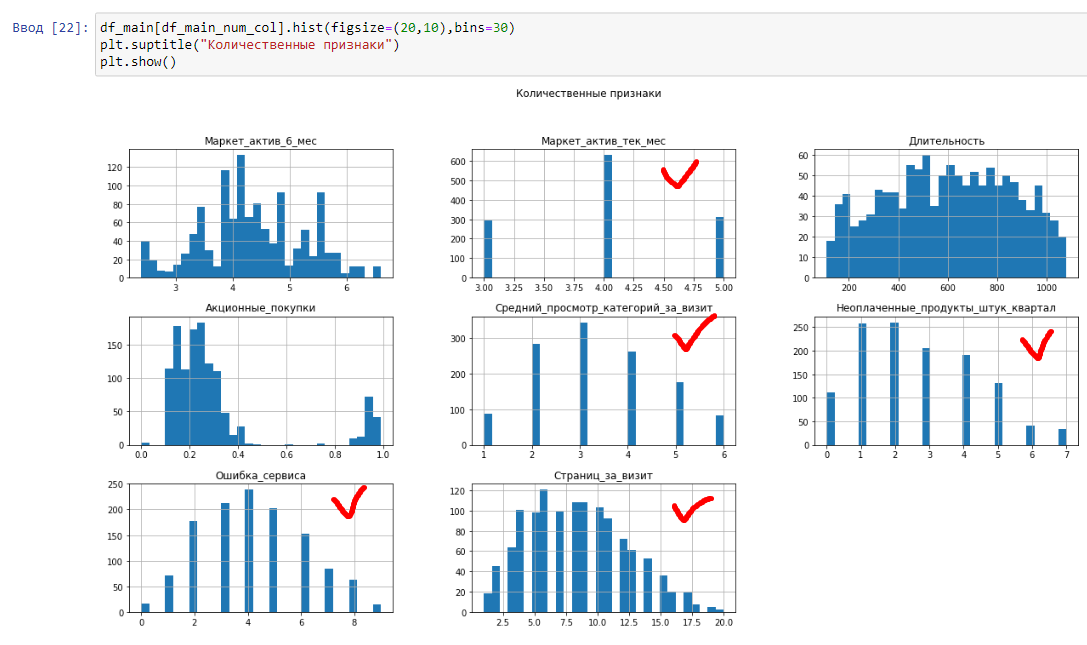

Ряд признаков в наших данных имеет дискретную природу (например это: 'Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', ... (*не привожу все названия из данных*)). Для графического анализа дискретных признаков нужнен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать **sns.countplot** или **.plot(kind='bar')**. Ты же для визуализации их используешь гистограмму.
    
---
Гистограммы обычно хорошо подходят для визуализации распределения непрерывных числовых признаков. Это могут быть такие признаки, как возраст, доход, количество продуктов в корзине, и т.д. Гистограммы помогают наглядно представить, как значения признака распределены по диапазону.

Для дискретных признаков, особенно если их значения ограничены и могут быть перечислены (например, категории, группы), столбчатые диаграммы или другие методы визуализации, такие как круговые диаграммы или ящики с усами, могут быть более подходящими.

Конечно, если у тебя есть дискретный признак, который принимает большое количество разных значений, и ты хочешь понять их распределение, ты можешь попробовать использовать гистограмму, но при этом учти, что столбцы будут разреженными и могут не давать полного представления о распределении.

**Важно подбирать подходящий тип графика в зависимости от природы данных и целей визуализации.**    
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поправил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

Все количественные признаки в данном случае имеют близкое к нормальному распредление, кроме акционных покупок, оно из себя представляет два ярковыраженных пиках рядом со значением 1 и 0.2

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

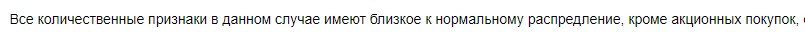

В наших данных есть признаки с нормальным распределением? Сколько таких признаков?

У нормального распределения не может быть никаких **скосов/смещений/мультимод/ассиметрии/выбросов** - нормальное распределение **АБСОЛЮТНО СИММЕТРИЧНОЕ**.

---
(Не)нормальность распределения данных проверяешь "на глаз", но это некорректно - есть вероятность ошибки (например в случае распределения похожего на Гауссиану). Что надо сделать чтобы строго подтвердить или опровергнуть нормальность распределения случайной величины?

Вот полезные материалы материалы на эту тему: https://education.yandex.ru/handbook/data-analysis/article/bazovye-statisticheskie-testy и https://education.yandex.ru/handbook/data-analysis/article/bazovye-statisticheskie-testy-v-python
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Добавил статистический тест на сраванение с нормальным распределением</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Отлично, спасибо за "строгую" проверку.
</div>

Рассмотрим распределение качественных признаков

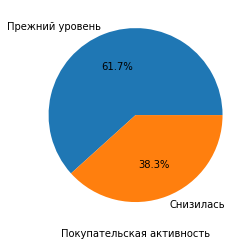

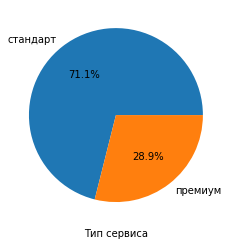

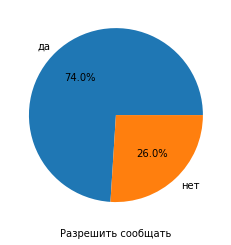

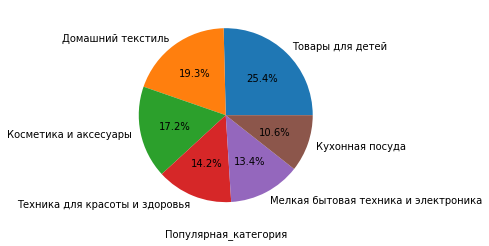

In [22]:
for column in df_main_cat_col:
    plt.pie(df_main[column].value_counts().values, labels=df_main[column].value_counts().index,autopct='%1.1f%%')
    plt.xlabel(column)
    plt.show()

<div class="alert alert-warning">
<b>Комментарий 👉</b>

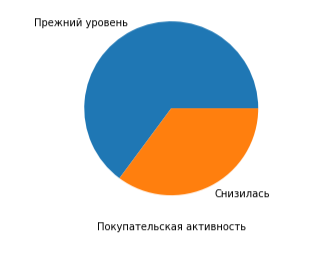

Наблюдаешь ли дисбаланс в целевой переменной (таргете)? **Если наблюдаешь, то как этот факт отражается на выборке метрики для моделей МО?**
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Использование pie-диаграмм для анализа категориальных признаков - отлично!
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

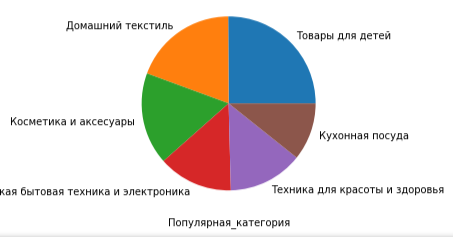

Специалисты по визуализации утверждают, что наш мозг?/глаз? **очень плохо "различает различия"** между "примерно одинаковыми" кусочками pie-диаграммы. Ну и соответственно рекомендуют использовать столбиковые?/столбцовые? диаграммы. 

Я ни в коем случае не против pie-диаграмм! Я просто призываю помнить об их обманчивой сущности )))

p.s. по факту приёма проекта я пришлю тебе набор книг в котором среди прочих будут и книги по визуализации.</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Тогда можно добавить процентовки, тоже по моему решает проблему</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Почитаешь потом в книжке .... ))))
</div>

Покупательская активность в большинстве своем осталась на прежнем уровне, большинство людей пользуется стандартным типом сервиса и разрешают присылать себе маркетинговые предложения. Категории распределяются довольно равно, но все равно можно выделить самые многочисленные - товары для детей, домашний текстиль и косметику и аксесуары

Перейдем ко второй таблице с данными о выручке, проделаем с ней аналогичные операции

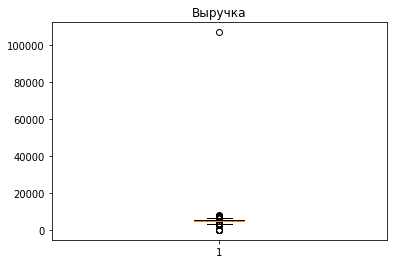

In [23]:
plt.title('Выручка')
plt.boxplot(df_market_money['Выручка'])
plt.show()

В данном случае лучше избавиться только от выброса выходящего за 10000 и равного нулю, остальные оставить, так как они довольно многочисленные

In [24]:
df_market_money = df_market_money[df_market_money['Выручка']<80000]
df_market_money = df_market_money[df_market_money['Выручка']>0]

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

    
    
Отлично, выброс удален!</div>

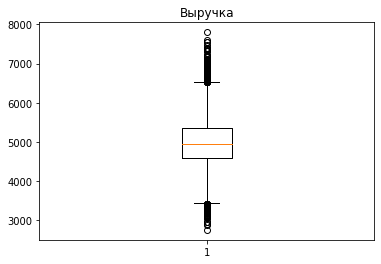

In [25]:
plt.title('Выручка')
plt.boxplot(df_market_money['Выручка'])
plt.show()

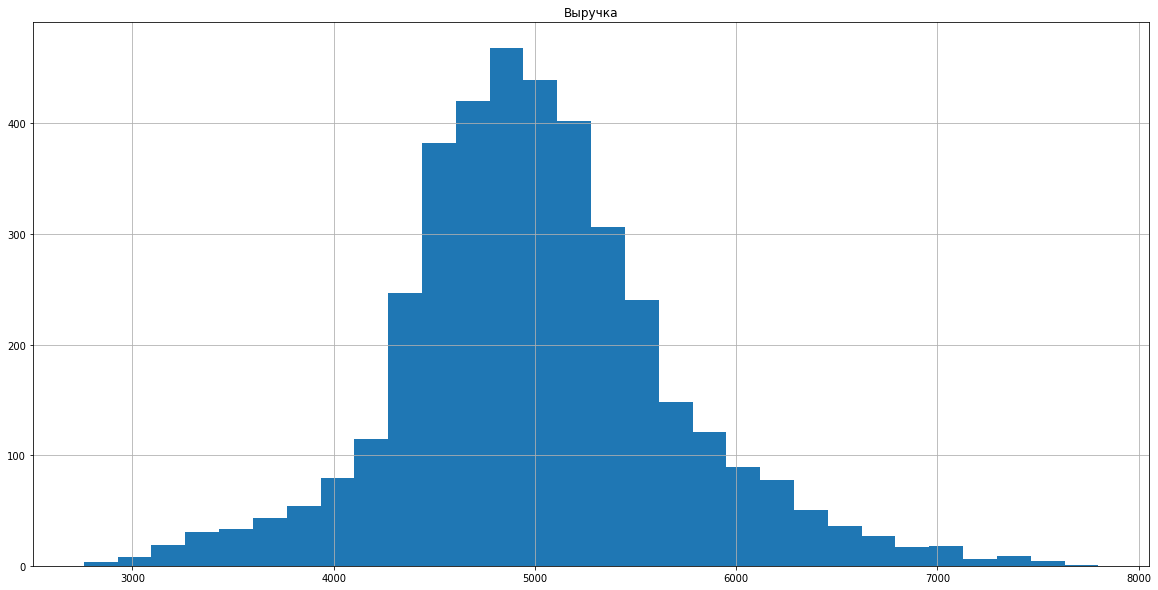

Нулевая гипотеза не подтвердилась


In [26]:
df_market_money['Выручка'].hist(figsize=(20,10),bins=30)
plt.title('Выручка')
plt.show()
if stats.kstest(df_market_money['Выручка'], 'norm', args=(df_market_money['Выручка'].mean(),stdev(df_market_money['Выручка'])), alternative='two-sided').pvalue>0.05:
    print('распределение нормальное')
else:
    print('Нулевая гипотеза не подтвердилась')

Избавились от выбросов, p-value все еще меньше 0.05, но есть визуальное сходство

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

**распределение у выручки нормальное** - это "на глаз". Можешь подтвердить утверждение строгой проверкой?
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Добавил статистический тест на сраванение с нормальным распределением</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

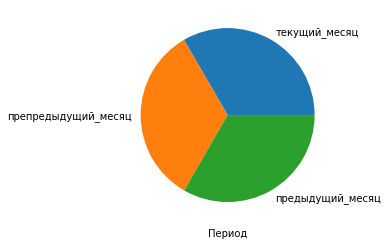

In [27]:
plt.pie(df_market_money['Период'].value_counts().values, labels=df_market_money['Период'].value_counts().index)
plt.xlabel('Период')
plt.show()


Все месяцы равномерно распределены

Перейдем к третьей таблице со временем проведенным на сайте в течение периода

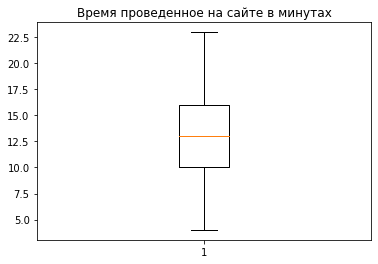

In [28]:
plt.title('Время проведенное на сайте в минутах')
plt.boxplot(df_time['минут'])
plt.show()

Нет выбросов - нет проблем, можно строить гистограмму

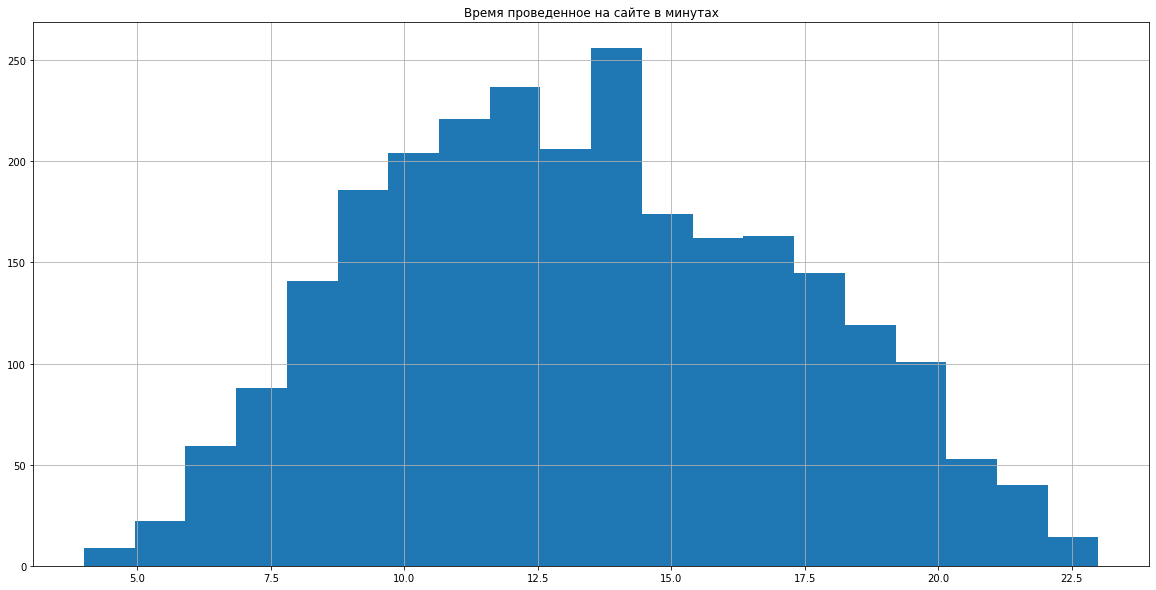

Нулевая гипотеза не подтвердилась


In [29]:
df_time['минут'].hist(figsize=(20,10),bins=20)
plt.title('Время проведенное на сайте в минутах')
plt.show()
if stats.kstest(df_time['минут'], 'norm', args=(df_time['минут'].mean(),stdev(df_time['минут'])), alternative='two-sided').pvalue>0.05:
    print('распределение нормальное')
else:
    print('Нулевая гипотеза не подтвердилась')

Время проведенное на сайте имеет p-value меньше 0.05, но все равно близко к нормальному по картинке, давайте разберемся с периодом аналогично второй таблице

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

**Время проведенное на сайте имеет нормальное распределение** - можно проверку?
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Добавил статистический тест на сраванение с нормальным распределением</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

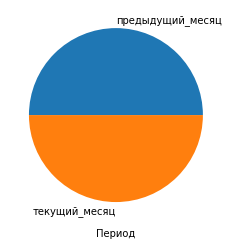

In [30]:
plt.pie(df_time['Период'].value_counts().values, labels=df_time['Период'].value_counts().index)
plt.xlabel('Период')
plt.show()

Распределение общего времени по периодам является равномерным

Теперь очередь дошла до 4 таблицы

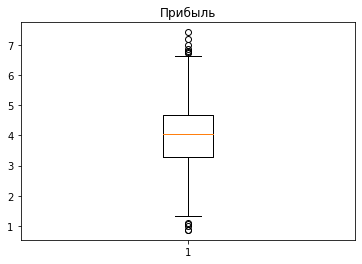

In [31]:
plt.title('Прибыль')
plt.boxplot(df_money['Прибыль'])
plt.show()

Нашлись выбросы, в данном случае можно их не щадить и убрать

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

**Нашлись выбросы, в данном случае можно их не щадить и убрать** - потому что боксплот так показал? А мысль аналитика где? Это нереальные цифры?
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поправил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

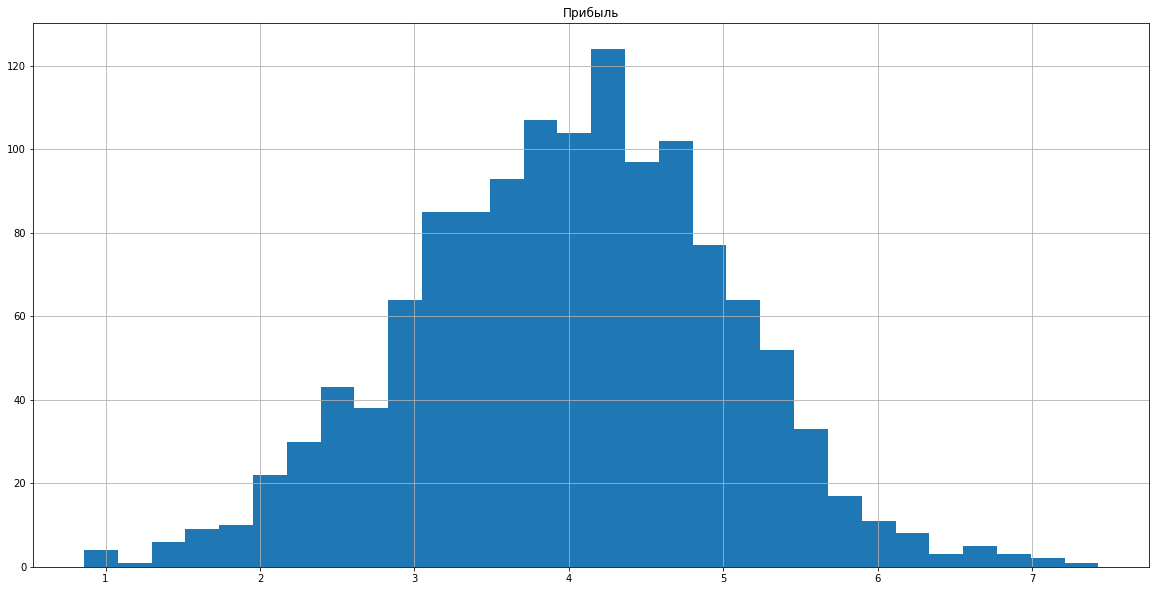

распределение нормальное


In [32]:
df_money['Прибыль'].hist(figsize=(20,10),bins=30)
plt.title('Прибыль')
plt.show()
if stats.kstest(df_money['Прибыль'], 'norm', args=(df_money['Прибыль'].mean(),stdev(df_money['Прибыль'])), alternative='two-sided').pvalue>0.05:
    print('распределение нормальное')
else:
    print('Нулевая гипотеза не подтвердилась')

Распределение прибыли продавца за последние три месяца является нормальным

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>НЕ ВЕРЮ, ВАУ</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

))))))))))
</div>

По итогу исследовательского анализа данных можно сказать, что подавляющее большинство количественным признаков не имеет нормальное распределение, кроме прибыли последней таблице. В плане категориальных признаков в первой таблице преобладал прежний уровень активности у клиента, так же большинство клиентов пользуется стандартным типом сервиса и разрешает присылать им маркетинговые прдложения. С точки зрения заинтересованности категориями товаров, все они распределены равномерно. в остальных таблицах количественные признаки имеют нормальное распределение. Периоды в талице со временем и выручкой распределены равно по понятным причинам

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

**можно сказать, что подавляющее большинство количественным признаков имеет нормальное распределение** - нет, этого сказать нельзя без подтверждения статистическим тестом.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Добавил статистический тест на сраванение с нормальным распределением</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Данные загружены, отлично.

Хорошо, что применяешь метод .head()/.sample() таким образом в память не будет загружен весь датасет, объем которого может быть огромным.

Методы .info, .describe, .value_counts(), .unique() как правило часто встречаются и обязательны к применению в задачах по исследованию данных, ведь с их помощью можно получить первые инсайты. 

Итак, мы провели предварительный анализ данных, проверили данные на наличие пропусков и затем обработали их (аргументированно заполнили / удалили / оставили как есть). Провели графический анализ. Сделали и озвучили выводы. Теперь можно приступать собственно к моделированию и ответам на вопросы проекта.

</div>

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>


**Этот шаг спасет твою аналитику (и карьеру):** классический кейс - к аналитику (неважно: DA-аналитику, DS-аналитику, ML-инженеру) прибегает его начальник с горящими глазами: «Срочно нужно посчитать метрики, отчет нужен вчера, Я ЖДУУУУУУУУ!!!!!!!!!!!!!!!!!!!!!!». Аналитик лезет в сырые данные, быстро собирает дашборд … и всё. Ни тебе проверки распределений, ни поиска выбросов, ни визуализации. Начальник на следующий день презентует эти цифры как истину в последней инстанции. А потом на них строятся бизнес-решения стоимостью десятки-сотни миллионов рублей … 

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>ТАК ДЕЛАТЬ НЕЛЬЗЯ! НИКОГДА!!!</u></summary>

Исследовательский анализ данных (EDA — Exploratory Data Analysis) — это первый и обязательный шаг перед тем, как ты начнёшь считать метрики, строить модели или делать выводы. Он помогает понять, с чем ты на самом деле работаешь, выявить ошибки и аномалии, а самое главное, не попасть в ловушку красивых, но ложных цифр.

Особенно критично это в машинном обучении. Когда ты обучаешь модель на плохих данных, хороший результат невозможен в принципе. В этом смысле работает железное правило: garbage in — garbage out.

Что входит в EDA?

✔️ Осмотр данных. Сколько строк? Какие типы колонок? Что выглядит странно? Уже на этом этапе можно поймать очевидные ошибки. Используй .info(), .describe(), загляни в начало и конец таблицы, проверь типы.

✔️ Пропуски и дубликаты. Пропуски не всегда нужно удалять — иногда лучше заполнить их медианой, модой или предсказанными значениями. А дубликаты — это не только точные копии строк. Часто бывают неявные: например, у одного пользователя два одинаковых заказа с разными ID.

✔️ Очистка и предобработка. Проверка категориальных значений, работа с форматами, единообразие записи. Например, если у тебя в колонке есть и «Санкт-Петербург» и «СПБ» и «Питер», то без нормализации это три разных значения. А если даты хранятся как строки — ты не сможешь нормально их анализировать.

✔️ Выбросы и аномалии. Просто посчитать среднее недостаточно. Построй распределение, используй boxplot. Эти графики мгновенно покажут, где данные выбиваются за границы нормы. И не забывай: один выброс может испортить тебе весь анализ.

✔️ Визуализация. Даже простой scatter plot может рассказать тебе гораздо больше, чем набор агрегатов. Иногда взаимосвязь между переменными становится очевидной только когда ты её увидишь, а не посчитаешь.

EDA — это не про «поковыряться в данных». Это про понять, что ты анализируешь, и быть уверенным в своих выводах. Это защита от ошибок, которые ты даже не успел заметить.

Теперь давай разберём первый и самый недооценённый шаг в исследовательском анализе: осмотр данных.

Представь, что ты лезешь в базу и ... сразу пишешь groupby() или строишь график? Это ловушка. Начинать нужно не с расчётов, а с банального знакомства с тем, что у тебя вообще в руках. Осмотр данных — это как включить свет в темной комнате. Сразу видно, где пыльно, а где стоит тумбочка, об которую легко споткнуться.

Первым делом смотри на объем данных: df.shape покажет, сколько строк и колонок. Иногда там вообще пара десятков строк — и это уже повод позвать дата-инженера. 
Дальше — названия колонок. Через df.columns можно заметить лишние пробелы, странные символы, дубли названий. Здесь же удобно сразу стандартизировать названия: убрать русские слова и привести к единому стилю ("snake_case" ван лав). Такие вещи не бросаются в глаза, но потом ломают пайплайн.

Теперь — в бой идет df.info(). Это твой лучший друг. Он покажет:

▪️какие типы данных у колонок,
▪️сколько ненулевых значений,
▪️сколько памяти жрёт датафрейм.

Обрати внимание: если в колонке написано, что у неё 80 000 непустых значений, а в df.shape[0] у тебя 100 000 — значит, 20% пропусков. Это серьёзно. 
Ещё один лайфхак: если колонка выглядит пустой, но info() говорит, что там всё заполнено — проверь, не строки ли там вроде " " или "None". Это визуальные, а не настоящие пропуски. Так что df.replace() тебе в помощь.

Если всё типы данных соответствуют ожиданиям — отлично. Если нет — можно наткнуться на неприятности. Например, object вместо чисел или дат — и ты не сможешь нормально группировать, фильтровать, делить на категории. В таких случаях сразу меняй тип или уточняй источник.

Следом подключай df.describe(). Это быстрый способ понять, как «живут» числовые данные. Сравни среднее и медиану — это может подсветить асимметричное распределение. Проверь минимум и максимум — там часто сидят выбросы или ошибки: отрицательные значения там, где их быть не должно, нули в колонке с деньгами, тысячи категорий у рейтинга от 1 до 5.

Дополнительно пригодится .nunique(): иногда колонка кажется категориальной, а там каждый второй элемент уникален. Это уже почти ID, и скорее всего — не то, что ты хотел анализировать.

И не забывай смотреть глазами. df.head(), df.tail() — быстрый способ поймать неявные проблемы. Например, даты, которые лежат строками. Или списки внутри ячеек. Или дубли с разницей в один символ. В табличке может быть много неожиданного — особенно если её собирали в два этапа, три человека, а выгружал четвёртый.

Осмотр данных — это про внимательность и здравый смысл. Здесь ты ловишь грубые баги, структурные проблемы и мусор, который может незаметно утащить твою аналитику не туда. А ещё — экономишь себе кучу времени, потому что не придется всё переделывать после того, как уже построен отчёт.

</details>
<br>
<br>
</div>


# Шаг 4. Объединение таблиц

Давайте объединим три основные таблицы в одну, четвертую не трогаем, так как она нам не понадобится

In [33]:
df_time_tek = df_time[df_time['Период']=='текущий_месяц']
df_time_tek = df_time_tek.drop('Период',axis=1)
df_time_pred = df_time[df_time['Период']=='предыдущий_месяц']
df_time_pred = df_time_pred.drop('Период',axis=1)

df_market_money_tek = df_market_money[df_market_money['Период']=='текущий_месяц']
df_market_money_tek = df_market_money_tek.drop('Период',axis=1)
df_market_money_pred = df_market_money[df_market_money['Период']=='предыдущий_месяц']
df_market_money_pred = df_market_money_pred.drop('Период',axis=1)
df_market_money_prepre = df_market_money[df_market_money['Период']=='препредыдущий_месяц']
df_market_money_prepre = df_market_money_prepre.drop('Период',axis=1)

In [34]:
df_main = pd.merge(df_main,df_time_tek,on='id',how='left')
df_main = pd.merge(df_main,df_time_pred,on='id',how='left')
df_main = pd.merge(df_main,df_market_money_tek,on='id',how='left')
df_main = pd.merge(df_main,df_market_money_pred,on='id',how='left')
df_main = pd.merge(df_main,df_market_money_prepre,on='id',how='left')

df_main = df_main.rename(columns={'минут_x':'Время_за_текущий_месяц',
                                  'минут_y':'Время_за_предыдущий_месяц',
                                  'Выручка_x':'Выручка_за_текущий_месяц',
                                  'Выручка_y':'Выручка_за_предыдущий_месяц',
                                  'Выручка':'Выручка_за_препредыдущий_месяц',})

display(df_main)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Время_за_текущий_месяц,Время_за_предыдущий_месяц,Выручка_за_текущий_месяц,Выручка_за_предыдущий_месяц,Выручка_за_препредыдущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,14,13,3293.1,NaN,NaN
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,10,12,4971.6,5216.0,4472.0
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,13,8,5058.4,5457.5,4826.0
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,13,11,6610.4,6158.0,4793.0
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,11,8,5872.5,5807.5,4594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,7,14,4741.7,3664.0,4704.0
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,11,12,5353.0,4729.0,5299.0
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,18,12,5139.2,5160.0,5334.0
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,7,18,5224.6,4923.0,4725.0


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Есть, отлично! Из "длинного" датафрейма сделали "широкий". Ровно то, что и требуется:
    
</div>

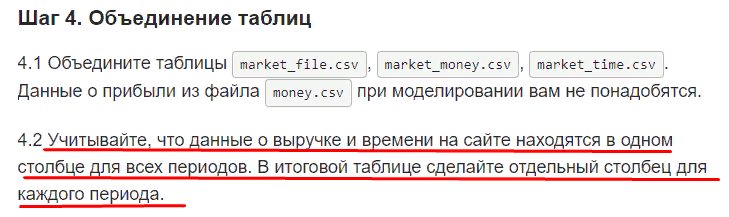

Появились пропуски, но ничего, мы их потом в шаге с пайплайнами заполним средним значением

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Откуда в этих строках пропуски?  Заполнение пропусков средним **ПОСЛЕ** объединения - это плохой способ (так у нас нет понимания откуда пропуски взялись). Следует разобраться со всеми записями в о всех датафреймах **ДО ОБЪЕДИНЕНИЯ** - понять есть ли в данных (которые "дошли" до объединения) проблемы. И да, наводка на мысль: в данных НЕ ДОЛЖНО быть никаких проблем. В итоге, после объединения ничего удалять и/или заполнять не надо.
</div>

# Шаг 5. Корреляционный анализ данных

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Смотришь скоррелированность признаков - отлично! Об этом чуть ниже подробней напишу....

---
Phi_K correlation представляет собой инструмент для вычисления и визуализации корреляции между категориальными и количественными переменными. Она может быть полезной в анализе данных перед построением моделей машинного обучения, так как позволяет обнаружить скрытые взаимосвязи между переменными, которые могли бы остаться незамеченными при обычных методах корреляционного анализа.
Преимущества использования **phik**:

1. **Учет категориальных переменных**: Традиционные методы вычисления корреляции, такие как коэффициент корреляции Пирсона, применяются только к количественным переменным. phik позволяет вычислять корреляцию между категориальными и количественными переменными, что делает его мощным инструментом для анализа разнообразных типов данных.

2. **Обнаружение нелинейных зависимостей**: phik способен обнаруживать нелинейные связи между переменными, которые могли бы быть упущены традиционными методами. Это особенно важно в анализе данных, где зависимости могут быть сложными и нелинейными (что может влиять на твой выбор признаков для моделей МО).

3. **Подходит для больших наборов данных**: phik обладает хорошей масштабируемостью, что позволяет использовать его для анализа больших наборов данных без серьезного снижения производительности.

4. **Визуализация результатов**: Библиотека предоставляет инструменты для визуализации матрицы корреляции между переменными, что помогает лучше понимать зависимости в данных.

p.s. у этой библиотеки есть ограничение с которым я например сталкивался: когда в даных есть столбцы с очень большим количеством уникальных значений, то phik может "упасть" с сообщением об ошибке (суть которого в том, что не хватает памяти для обработки такого количества "уников"). ПРи этом на компьютере у меня 32 Гб памяти и большая часть её не занята. Я подозреваю что это некое внутреннее ограничение библиотеки.
</div>

In [35]:
df_main_interval_col = ['Маркет_актив_6_мес',
                  'Длительность',
                  'Акционные_покупки',
                  'Время_за_текущий_месяц',
                  'Время_за_предыдущий_месяц',
                  'Выручка_за_текущий_месяц',
                  'Выручка_за_предыдущий_месяц',
                  'Выручка_за_препредыдущий_месяц']


In [36]:
df_main.drop('id',axis=1).phik_matrix(interval_cols=df_main_interval_col)

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Время_за_текущий_месяц,Время_за_предыдущий_месяц,Выручка_за_текущий_месяц,Выручка_за_предыдущий_месяц,Выручка_за_препредыдущий_месяц
Покупательская активность,1.000000,0.132277,0.000000,0.545630,0.000000,0.089995,0.498954,0.297053,0.535431,0.402574,0.219823,0.748398,0.575876,0.683726,0.197806,0.227280,0.495174
Тип сервиса,0.132277,1.000000,0.286015,0.092477,0.044600,0.405711,0.046192,0.066787,0.181069,0.114099,0.073367,0.088330,0.000000,0.129821,0.121108,0.000000,0.068507
Разрешить сообщать,0.000000,0.286015,1.000000,0.000000,0.052267,0.249165,0.000000,0.071386,0.071829,0.162462,0.000000,0.096469,0.000000,0.041988,0.062021,0.079830,0.000000
Маркет_актив_6_мес,0.545630,0.092477,0.000000,1.000000,0.078349,0.000000,0.241500,0.149938,0.206398,0.215234,0.141742,0.373082,0.328372,0.363694,0.035866,0.149129,0.312243
Маркет_актив_тек_мес,0.000000,0.044600,0.052267,0.078349,1.000000,0.178717,0.011341,0.132810,0.247489,0.144497,0.115543,0.000000,0.064532,0.103696,0.000000,0.054683,0.000000
Длительность,0.089995,0.405711,0.249165,0.000000,0.178717,1.000000,0.124509,0.000000,0.191292,0.115885,0.185802,0.111171,0.106626,0.000000,0.141601,0.116325,0.112349
Акционные_покупки,0.498954,0.046192,0.000000,0.241500,0.011341,0.124509,1.000000,0.102826,0.196895,0.245399,0.079912,0.343749,0.264620,0.261309,0.087261,0.056164,0.191116
Популярная_категория,0.297053,0.066787,0.071386,0.149938,0.132810,0.000000,0.102826,1.000000,0.224104,0.254464,0.000000,0.175765,0.091974,0.195037,0.235239,0.250974,0.045814
Средний_просмотр_категорий_за_визит,0.535431,0.181069,0.071829,0.206398,0.247489,0.191292,0.196895,0.224104,1.000000,0.335158,0.067988,0.291334,0.183393,0.158577,0.101008,0.100332,0.176770
Неоплаченные_продукты_штук_квартал,0.402574,0.114099,0.162462,0.215234,0.144497,0.115885,0.245399,0.254464,0.335158,1.000000,0.016883,0.307712,0.168824,0.195247,0.165441,0.193752,0.189721


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

При использовании **phik** крайне важно настроить параметр **interval_cols**, передав ему список с названиями непрерывных признаков: если этого не сделать, библиотека своими силами будет пытаться разнести признаки по типам, и она зачастую делает в этом ошибки - от этого в свою очередь мы получаем некорректную оценку корреляций, так как от типа признака зависит метод оценки корреляции.

---
Возможный вопрос: **... я все равно не понимаю зачем в interval_cols передавать именно непрерывные признаки, после моих исправлений, матрица практически не изменилась ...**

Ответ: итак, зачем в interval_cols передавать именно непрерывные признаки? Библиотека phik рассчитывает обобщённую корреляцию между переменными, в том числе категориальными и числовыми. Для числовых (интервальных) признаков phik автоматически бинит значения в интервалы (бины), чтобы можно было строить кросс-таблицы и считать корреляцию.

Непрерывные признаки (например, "выручка", "длительность" с большим количеством уникальных значений) хорошо подходят для биннинга, потому что их значения равномерно распределены по диапазону, и разделение на бины даёт осмысленное представление о распределении значений.

Дискретные признаки (например, "количество акционных покупок" с 10 уникальными значениями) при биннинге могут терять смысл: если уникальных значений мало, то бины будут крупными и не отразят реальную структуру данных.

*Почему матрица почти не изменилась после исправлений?*
Если убралать из interval_cols признаки с малым числом уникальных значений (дискретные), а оставить только действительно непрерывные, то биннинг станет более корректным, но если в данных изначально мало действительно непрерывных признаков, то итоговая матрица phik действительно изменится не сильно. Это связано с тем, что phik хорошо работает и с категориальными переменными, и если большинство признаков дискретные, то их вклад в матрицу корреляций будет примерно одинаковым независимо от того, как они определены (категориальными или интервальными).

*Почему не стоит передавать дискретные признаки в interval_cols?*
- Потеря информации: Если признак с 20 уникальными значениями разбить на 10 бинов, то в каждом бине окажется по 2 значения — это грубое усреднение и потеря детализации.

- Смысл биннинга: Для дискретных признаков биннинг не добавляет смысла, а наоборот, может исказить структуру данных.

- Категориальные признаки: Лучше оставить такие признаки категориальными — phik корректно считает корреляции между категориальными переменными без биннинга.

*Если нет непрерывных признаков — можно ли уменьшить число бинов?*
Да, можно уменьшить параметр bins (например, до 5), чтобы избежать чрезмерной агрегации, но это не решит проблему, если признак изначально дискретный. Биннинг нужен для того, чтобы "категоризировать" непрерывные значения, а не дискретные.

</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

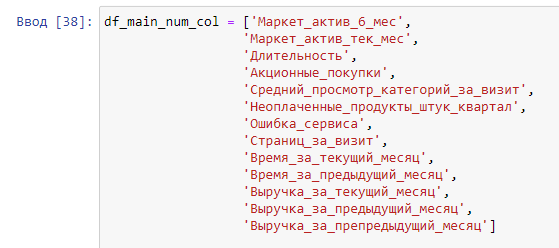

Все ли признаки в interval_cols сейчас действительно непрерывные? Или "затесались" в список ещё и дискретные?
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поправил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

Исходя из таблицы корреляций можно сказать, что нет признаков, которые имеют мультиколлинеарность

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Несколько моментов "на будущее" (сейчас забегаю чуть вперед, но будущем это будет важно) которые я хотел озвучить перед переходом к собственно исследованию (некоторые из этих моментов в твоем проекте реализованы):
    
- имеет смысл критично посмотреть на данные с точки зрения наличия пропусков в признаках (вопрос: все ли ml-модели "любят" пропуски?) и обработать или удалить их 
    
- имеет смысл явно обозначить какую задачу мы будем решать: с учителем / без учителя, классификации / регрессии ...
    
- в моделях бинарной классификации (это ровным счётом наш случай!) имеет смысл смотреть на баланс классов. Два взгляда (с разных сторон) на эту проблему тут: https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/ и https://habr.com/ru/post/349078/
    
- имеет смысл смотреть на корреляцию признаков. При высокой их степени коррелированности возникает проблема  мультиколлиниарность признаков. Проблема "мультиколлинеарности" это и про переобучение модели и про её интерпретируемость и про сложность модели (содержание в модели избыточного количества переменных). В чем негативный эффект сложной модели? Вот в чем: усложняется интерпретация параметров, оценки параметров ненадежны – получаются большие стандартные ошибки, которые меняются с изменением объема наблюдений, что делает модель регрессии непригодной для прогнозирования.

<br>
<br>
<details>
<summary style="color: blue; font-size: 18px; font-weight: bold;">▶ <u>Подробнее ...</u></summary>

Вот несколько причин, почему проблема мультиколлинеарности (МК) важна:

1. Неоднозначность коэффициентов: МК делает оценку коэффициентов модели неустойчивой. Когда существует сильная корреляция между признаками, модель становится неспособной разделить влияние каждого признака на целевую переменную. Это может привести к неоднозначным и неправильным оценкам коэффициентов, что затрудняет интерпретацию важности каждого признака. Согласись - это важно, чтобы результат, который выдает модель можно было бы понять и объяснить с точки зрения предметной области. В случае включения в модель высокоскоррелированных признаков - может случиться так, что коэффициенты (да, проблема присуща моделям линейным ... регрессия среди них!) могут менять знаки и попытка объяснения предметной области с помощью этих коэффициентов будет противоречить здравому смыслу.

2. Плохая обобщающая способность: МК может снизить способность модели обобщаться на новые данные. Когда сильно коррелированные признаки присутствуют в модели, модель может стать "перегенерированной" и склонной к переобучению на обучающих данных. В результате модель может показывать хорошую производительность на обучающих данных, но плохо обобщаться на новые данные.

3. Ухудшение точности и устойчивости модели: МК может привести к численным проблемам при решении линейных уравнений, используемых для оценки коэффициентов модели. Это может привести к нестабильности и неточности оценок. Кроме того, небольшие изменения в данных могут привести к большим изменениям в оценках коэффициентов модели, что делает модель неустойчивой.

4. Избыточность информации: Когда признаки сильно коррелированы, они предоставляют практически одинаковую информацию о целевой переменной. Такая избыточность может привести к неэффективности модели и увеличению сложности модели без значительного улучшения производительности.

В целом, МК может иметь отрицательное влияние на производительность, стабильность, интерпретируемость и обобщающую способность.
    
---
Для деревянных моделей и моделей градиентного бустинга проблема МК  не является такой критической, как для линейных моделей. Вот несколько причин:

1. Нелинейность: Деревянные модели и модели градиентного бустинга являются нелинейными моделями. Они способны обрабатывать сложные взаимодействия между признаками и целевой переменной. В отличие от линейных моделей, они могут более гибко адаптироваться к наличию мультиколлинеарности в данных.

2. Рекурсивное разбиение: Деревья принятия решений в деревянных моделях и моделях градиентного бустинга используют рекурсивное разбиение для разделения данных на более чистые группы. Это означает, что деревья могут независимо выбирать разные признаки для разделения, даже если они сильно коррелированы. Таким образом, деревья могут игнорировать мультиколлинеарность и использовать другие признаки для принятия решений.

3. Ансамбль деревьев: Модели градиентного бустинга строятся на основе ансамбля слабых деревьев решений. Каждое дерево добавляется постепенно для уменьшения ошибки предыдущих деревьев. Это позволяет модели градиентного бустинга восстанавливать ошибки, вызванные мультиколлинеарностью, поэтапно улучшая прогнозы.

Хотя мультиколлинеарность не является проблемой в деревянных моделях и моделях градиентного бустинга в той же степени, что и в линейных моделях, она все еще может оказывать влияние на производительность и интерпретируемость модели. Сильно коррелированные признаки могут вносить избыточность в модель и увеличивать сложность, не принося значительного улучшения в прогнозах. Поэтому, хотя деревья могут быть более устойчивыми к мультиколлинеарности, все же рекомендуется выполнять анализ корреляции признаков и, при необходимости, применять методы снижения размерности или регуляризации для улучшения модели.
    
Вот классная статья. Простым языком, на примере показана проблема. А также, что важно - разобраны варианты как её (проблему) победить. Статья: https://habr.com/ru/company/akbarsdigital/blog/592493/ 
    
</details>
<br>
<br>    
</div>

# Шаг 6. Использование пайплайнов

На данном этапе используя пайплайны мы переберем модели, гиперпараметры к ним, методы обработки данных и найдем самое оптимальное сочетание, которое дает наибольшую точность.

С точки зрения машинного обучения мы имеем дело с задачей бинарной классификации, поэтому будут использоваться модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC()

В нашем случае очевидно, что нам важнее всего избежать ложноположительных ошибок, так как самое главное это найти всех клиентов, у которых может снизиться активность, то есть нас интересует метрика precision

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Есть, ОТЛИЧНО! Вижу обоснование выбора и использования конкретной ml-метрики в твоем проекте!
</div>

Для начала разделим наши данные на выборки и отсортируем признаки на категории для подготовки к обучению модели

In [37]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = df_main.drop(['Покупательская активность','id'],axis=1)
y = df_main['Покупательская активность']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=df_main['Покупательская активность'])


ohe_columns = ['Популярная_категория']
ord_columns = ['Тип сервиса', 'Разрешить сообщать']
num_columns = df_main.drop(['Популярная_категория',
                            'Тип сервиса',
                            'Разрешить сообщать',
                            'Покупательская активность',
                            'id'],axis=1).columns


<div class="alert alert-warning">
<b>Комментарий 👉</b>



Обычно я set'ы, настройки и константы также размещаю в **самой первой ячейке "тетрадки", там где импорты, сразу после них. Пример скрина из моего текущего рабочего проекта:
</div>

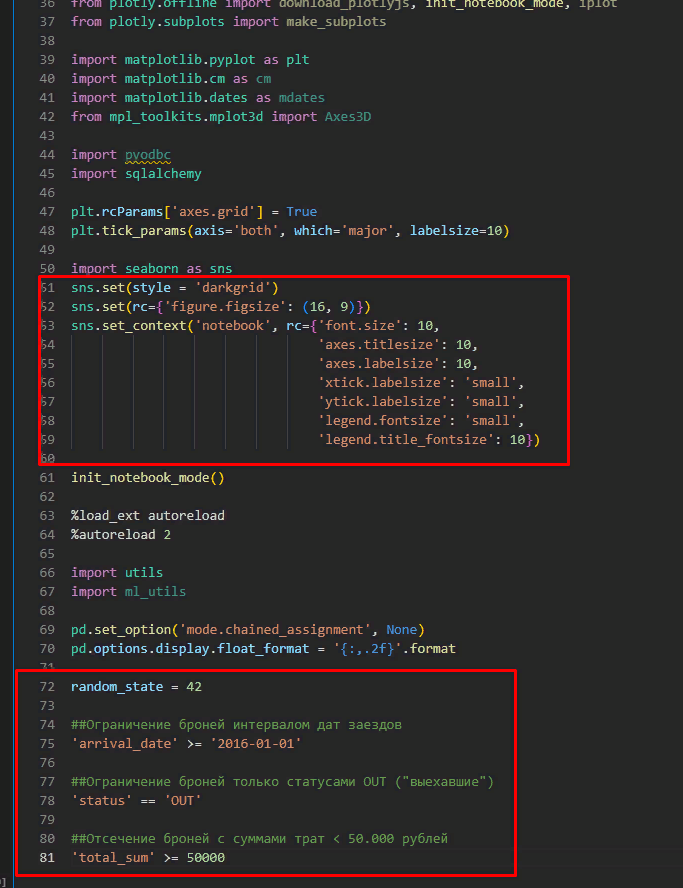

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

1. Здесь хорошо, происходит фиксация random_state. Воспроизводимость результатов разбиения выборки на обучающую (тренировочную) / тестовую мы обеспечили, значит при всех последующих запусках нашего кода подвыборки будут идентичными.
    
2. Доли размеров train/test 3:1 - хорошо.

3. Молодец что используешь параметр stratify. Использование stratify позволит сохранить баланс меток классов 1/0 ("снизится"/"не снизится") в 2х выборках (этот момент важен **особенно** в случае сильного дисбаланса классов в данных). Но конечно stratify это "не про" решение проблемы с "выравниванием" количества строк (с определенным классом) именно в данных.
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Я бы рекомендовал после разбиения данных на выборки посмотреть на их **размеры и размерности**. Метод shape для этого - идеальный помощник. "Цифры" по выборкам покажут верно ли мы произвели "разделение" данных.

p.s. так (**псевдокод**): X_train.shape[0] – «покажет» количество строк в тренировочной выборке, а X_train.shape[1] - количество столбцов в ней же. Ну а X_train.shape – выведет размерность train'а в виде кортежа с 2мя значениями (первое число – количество строк, второе – столбцов).</div>

Избавимся от выбросов в числовых признаках

In [38]:
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train[num_columns] = num_imputer.fit_transform(X_train[num_columns])
X_test[num_columns] = num_imputer.transform(X_test[num_columns])

Напишем часть пайплайна для OneHotEncoder

In [39]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>



Стоит настроить работу энкодера OneHotEncoder на работу с неизвестными значениями признаков - сейчас энкодер "при встрече с неизвестной категорией" (это может случиться в проде) - будет выбрасывать ошибку. Для непрерывности процесса моделирования **следует обязательно** настроить параметр **handle_unknown='ignore'**, чтобы новые, ранее неизвестные (на этапе обучения модели) значения признаков игнорировались и не включались в итоговую матрицу. Когда ты "включишь" параметр **handle_unknown='ignore'**, то параметра **drop='first'** рядом с ним быть НЕ ДОЛЖНО.

---
Почему параметра **drop='first'** НЕ ДОЛЖНО быть рядом с **handle_unknown='ignore'**? 
Во-первых, эти 2 параметра не работают вместе на той версии scikit-learn (0.24), которая развернута сейчас на Платформе. 
Во-вторых, при их одновременном использовании будет наблюдаться следующая проблема:  и пропущенная (dropped) первая категория, и любые неизвестные категории будут кодироваться одинаково - вектором из всех нулей. Соответственно станет невозможным различить их после трансформации признаков.

</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поправил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

Напишем часть пайплайна для OrdinalEncoder

In [40]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ['нет', 'да'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>



OrdinalEncoder у тебя настроен на работу с неизвестными категориями.
</div>

Объединим эти пайалайны в один по подготовке данных

In [41]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
    
)
data_preprocessor.fit(X_train)
ohe_transformer = data_preprocessor.named_transformers_['ohe'].named_steps['ohe']
new_column_names = ohe_transformer.get_feature_names_out(ohe_columns)

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

**Использование трансформеров и пайплайнов - СУПЕР!**
    
---
Преимущества использования трансформеров:

1. **Гибкость и модульность**: Трансформеры позволяют разбить сложные операции по предобработке данных на более мелкие и легко управляемые компоненты. Это делает код более читаемым и модульным.

2. **Переиспользование**: Трансформеры могут быть повторно использованы на разных этапах анализа данных и построения моделей. Например, ты можешь создать трансформер для нормализации данных и использовать его как в обучении модели, так и на этапе инференса.

3. **Работа с разными типами данных**: Трансформеры могут обрабатывать различные типы данных, включая текст, изображения и числовые значения. Это позволяет тебе создавать единые интерфейсы для предобработки разнообразных данных.

Преимущества использования пайплайнов:

1. **Структурированность**: Пайплайны помогают организовать последовательность шагов обработки данных, начиная с загрузки и заканчивая подготовкой к обучению модели. Это обеспечивает структурированность и позволяет легко вносить изменения.

2. **Поддержание кода**: Пайплайны сокращают вероятность ошибок и упрощают поддержание кода. Отслеживание последовательности операций делает процесс отладки и оптимизации более прозрачным.

3. **Масштабируемость**: Пайплайны могут быть легко расширены новыми этапами обработки данных. Это позволяет добавлять новые операции без переписывания всего кода.

Объединение трансформеров и пайплайнов позволяет создавать чистые, структурированные и гибкие рабочие процессы для подготовки данных. Например, ты можешь создать трансформеры для преобразования текстовых данных и числовых значений, а затем построить пайплайн, который последовательно применяет эти трансформеры и завершается обучением модели. Это существенно упростит управление и анализ данных перед обучением моделей машинного обучения.

Несколько ссылок (*нужен vpn для подключения к сайтам + возможно понадобиться поиском поискать названия статей - если они были перемещены*), которые позволят погрузиться в тему:

- [трансформеры](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) и [пайплайны](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) для организации предобработки (кодирования, масштабирования) и модели
- применение пайплайна [A Basic Introduction to Pipelines in Scikit Learn](https://towardsdatascience.com/a-basic-introduction-to-pipelines-in-scikit-learn-bd4cee34ad95)
- большой гайд как можно комбинировать разные этапы предобработки [Pipelines and composite estimators](https://scikit-learn.org/stable/modules/compose.html)
- или можно написать свой класс-трансформер [Custom Transformers and Pipelines in Python](https://towardsdatascience.com/custom-transformers-in-python-part-ii-6fe111fc82e4)
</div>
</div>


Пишем финальный пайплайн и параметры для перебора

In [42]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
     
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1')],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

Производим перебор

In [43]:
r_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=make_scorer(precision_score, average='binary',pos_label='Снизилась'),
    random_state=RANDOM_STATE,
    n_jobs=-1
)
r_search.fit(X_train, y_train)
print('Лучшая модель')
print()
print(r_search.best_estimator_)
print()
print ('Метрика лучшей модели', r_search.best_score_)
print()
print(r_search.best_params_)

preds = r_search.predict(X_test)

print(preds)

Лучшая модель

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Почему метрика поменялась на roc_auc? Выше ты говорил о precision.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поправил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

А зачем нам в проекте нужна была тестовая выборка? Почему она в этом разделе нигде не появилась и нигде не была использована?
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поправил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

In [44]:
best_pipeline = r_search.best_estimator_ 
model = best_pipeline.named_steps['models']

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Что и зачем происходит в этой ячейке?
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Что и зачем происходит в этой ячейке?
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Оба неактуальны.
</div>

Модель показывает хороший результат, была выбрана по итогу модель SVC, с rbf ядром, причем лучший результат показала модель при стандартизации StandardScaler()

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Для проверки модели на адекватность можно использовать DummyClassifier (из библиотеки sckit-learn).
    
p.s. (дополнительно, на перспективу!): можно было бы построить Confusion Matrix, чтобы детально посмотреть где ошибаются модели. Подробнее о Confusion Matrix здесь: https://neptune.ai/blog/evaluation-metrics-binary-classification     
</div>

# Шаг 7. Анализ важности признаков

Модель была выбранна нелинейная, поэтому использования метода Шепли невозможно, поэтому воспользуемся старым добрым удалением признаков

In [45]:
new_cols = ['Тип Сервиса',
            'Разрешить сообщать',
            'Маркет_актив_6_мес',
            'Маркет_актив_тек_мес',
            'Длительность',
            'Акционные_покупки',
            'Популярная_категория_Косметика и аксесуары',
            'Популярная_категория_Кухонная посуда',
            'Популярная_категория_Мелкая бытовая техника и электроника',
            'Популярная_категория_Техника для красоты и здоровья',
            'Популярная_категория_Товары для детей',
            'Средний_просмотр_категорий_за_визит',
            'Неоплаченные_продукты_штук_квартал',
            'Ошибка_сервиса',
            'Страниц_за_визит',
            'Время_за_текущий_месяц',
            'Время_за_предыдущий_месяц',
            'Выручка_за_текущий_месяц',
            'Выручка_за_предыдущий_месяц',
            'Выручка_за_препредыдущий_месяц']

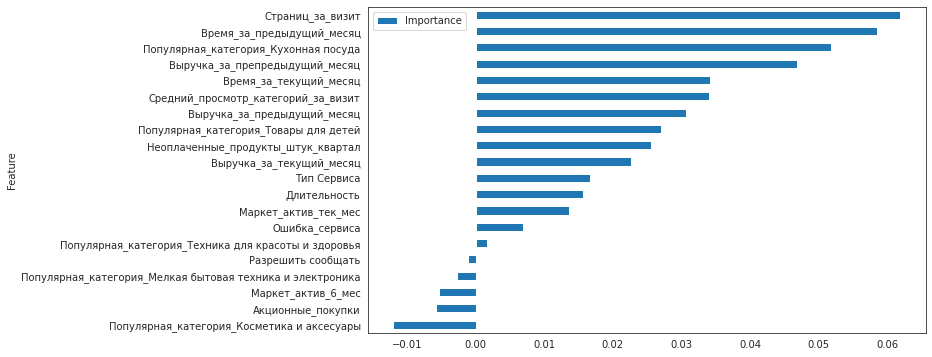

In [46]:
X_train = data_preprocessor.fit_transform(X_train)
X_test = data_preprocessor.transform(X_test)
X_train = pd.DataFrame(X_train,columns=new_cols)
X_test = pd.DataFrame(X_test,columns=new_cols)
model.fit(X_train,y_train)
features_names = X_train.columns
result = permutation_importance(model, X_test, y_test, scoring=make_scorer(precision_score, average='binary',pos_label='Снизилась'),n_repeats=20,random_state=RANDOM_STATE)

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)); 


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Молодец, здесь ты делаешь то, что я редко обычно встречаю в проектах (я про визуализацию признаков, которые модель "посчитала" важными. Почему их анализ важен и полезен (несколько причин, почему важно тщательно "рассматривать" признаки):

1. **Информативность**: Признаки содержат информацию, которая помогает модели делать предсказания. Некоторые признаки могут быть более информативными, чем другие, и могут иметь сильное влияние на результаты модели. Понимание, какие признаки являются наиболее информативными, поможет сосредоточить усилия на сборе и анализе этих признаков, что в конечном итоге может привести к лучшим предсказаниям модели.

2. **Устранение шума и избыточности**: Некоторые признаки могут содержать шумовую или избыточную информацию, которая может негативно повлиять на работу модели. Анализ и отсев таких признаков помогут улучшить качество модели, устранить возможное переобучение и улучшить ее способность обобщать данные.

3. **Раскрытие взаимосвязей**: Изучение признаков может помочь обнаружить скрытые взаимосвязи и зависимости в данных. Например, два признака могут быть слабо информативными сами по себе, но в комбинации могут образовывать сильный предиктор. Исследование и понимание взаимосвязей между признаками может привести к созданию более сложных, но более мощных моделей.

4. **Сокращение размерности**: Некоторые наборы данных могут содержать большое количество признаков, и это может стать проблемой для обучения моделей. Сокращение размерности путем отбора наиболее важных признаков позволяет сократить вычислительную сложность, снизить вероятность переобучения и улучшить интерпретируемость модели.

5. **Интерпретируемость**: Понимание важности признаков также помогает интерпретировать результаты модели. Если мы знаем, какие признаки оказывают наибольшее влияние на предсказания, мы можем сделать более осознанные выводы и принимать меры на основе результатов   
</div>


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Мне требуется начальный код этой ячейки, чтобы получить обработанный датафрейм, потому что внутрь пайплайна мы засунуть обработку названий признаков с get_feature_names не можем, а если в ненешнем состоянии передать новые имены признаков из препроцессора, то SVC модель не мосжет расположить адекватно признаки, так как она обучалась на данных, которые она обозвала "x0, x1..." и так далее, поэтому пришлось заново ее обучить ведь сам поиск оптимальной модели никак не изменяет глобальную переменную с данными, я ознакомился с предоставленными ссылками, там есть как раз одна статья про анализ важности признаков, вот только там в примере нет OneHotEncoder'а, который убирает все названия столбцов, что делает задачу простейшей и бессмысленной по сравнению с той, что предложена в этом проекте, можно считать это моей "прогерской капитуляцией"</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Тогда на всякий случай оставлю объяснялку про пайплайну и shap.
    
Сам Shap строится без проблем в пару строк, если в него подать обычный датафрейм с подписанными колонками. Однако у нас здесь пайплайн. Поэтому нужно приложить некоторые усилия для того, чтобы вынуть из пайплайна названия фичей и подать в функцию графика в нужном нам виде датафрейма.
    
    
По Shap подойдет такой код:
    
```
    

X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
 
explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)
 
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
 
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
 
shap_values = explainer(X_test_2)
 
display(shap.plots.bar(shap_values, max_display=22))
shap.plots.beeswarm(shap_values, max_display=22) 


```
 
По идее, нам просто нужно подать в функцию shap.Explainer() модель и тренировочную выборку, а затем в функцию отрисовки графика shap.plots.bar() эксплейнер с тестовой выборкой explainer(X_test_2). 
    
Однако так как мы используем пайпланый, важно подавать в эксклейнер тренировочную выборку после масштабирования и кодирования Поэтому мы берем из пайплайна только соответствующие шаги и применяем к тренировочной выборке.
    
`X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)`
    
То же самое делаем с тестовой выборкой. 
    
`X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)`
    
И отдельным шагом сохраняем список с названиями столбцов:
    
`feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()`
    
После чего получаем датасет с колонками после масштабирования и экнодинга и их названиями.
    
`X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)`
    
Дальше оставется все это использовать:
    
```
shap_values = explainer(X_test_2)
 
display(shap.plots.bar(shap_values, max_display=22))    
    
```


Наиболее влиятельными на вердикт модели оказались признаки просмотра странниц, средний просмотр категорий за визит и время за препредыдущий месяц, также некоторые признаки получили отрицательную важность.

# Шаг 8. Сегментация покупателей

Как изучаемый сегмент было принято решение взять покупателей со сниженной активностью, так как вне зависимости от благосостояния клиента мы не хотим его терять и сохранять его вовлеченность в наш сайт. В первую очередь анализ будет основан на том, что модель посчитала самыми важными для вынесения вердикта признаками.

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Несмотря на то, что анализ клиентов в этом разделе не определяется жёстко в ТЗ - позволю  накидать несколько моментов про то, как это вижу я:
    
1. Выбираем сегмент и объясняем почему мы его выбрали. Тут делаем упор на бизнес - составляющую (мы ведь всем этим занимаемся не в сферическом вакууме, а для повышения экономической эффективности) и логику. Пример:

    "нас интересуют богатенькие клиенты, поэтому...", "нас интересуют те для кого модель предсказала высокую вероятность ухода, потому что...", "нас интересуют богатенькие и уходящие, потому что..."

- Или ориентируемся на результаты оценки важности признаков. Пример:

    "акционные покупки не показали высокую значимость на графиках shap, но если приглядеться, то yf графике beeswarm мы видим очень четкое разделение: высокие акционные покупики - высокая вероятность снижения, значит мы можем..." 

2.  У нас есть файл money, в нем содержится важная информация о прибыльности клиентов. Это наверно самый важный параметр с точки зрения бизнеса: клиент может много покупать, но прибыльность от него будет небольшой, или наоборот клиент может мало покупать, но он покупает товары которые продавать магазину выгодно. Чувствуешь разницу?! Стоит обогатить наши данные этой информацией
    
3. Используем результаты моделирования, а иначе зачем мы все это делали?!  Можно использовать результат predict_proba посмотрев на уверенность модели в том что клиент снижает активность - вот и вариант сегментации.  Можно использовать модель как источник вдохновения для выбора признаков (если модель считает признак важным для прогноза активности, то логично посмотреть на него поближе). Можно приглядеться на графики shap.beeswarm, увидев там что то интересное. Или можно все это использовать вместе.  Кстати можно подглядеть внутрь моделей не только с помощью shap, но и построить [plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) и там подсмотреть  комбинацию признаков с конкретными порогами, сделав упор на признаки - причины. Например проанализировав   plot_tree мы можем увидеть что для такой то группы товаров, при таком то значении акционных покупок и при таком то сервисе, высока доля не снижающих активность клиентов (ничего такого на самом деле нет, это просто пример). И мы сможем сделать более сложные маркетинговые предложения.

4. После выбора сегмента мы можем посмотреть усредненный портрет клиентов попавших в него, но сами по себе цифры нас не интересуют, нас интересует разница с клиентами не попавшими в сегмент. поэтому стоит проанализировать сегмент, указать на его отличия от остальных. для этого отлично подойдут графики countplot/pie (для категориальных) и гистограмму или boxplot (для количественных), а разбивке "наш сегмент" - "не наш сегмент"

5. И в конце составляем индивидуальные маркетинговые предложения для выбранного сегмента - иначе для чего мы всё это делали!?  При этом  выводы не должны быть слишком общими, напрмиер предложение "предложить акцию", это слишком общее предложение, лучше указать для кого, по какой группе товаров итп итд
    
p.s. еще можно посмотреть на динамику выручки по месяцам, в группировке по категориальным признакам (популярная категория, тип сервиса, разрешить сообщить), возможно тут получится увидеть что то интересное и сделать какие то маркетинговые предложения. Отслеживание динамики, как и сравнение, отличный способ найти в данных что то интересное.
</div>

In [47]:
df_main = pd.merge(df_main,df_money,on='id',how='left')
df_main_interval_cols = ['Маркет_актив_6_мес',
                         'Длительность', 
                         'Акционные_покупки',
                         'Прибыль']
df_main_down = df_main[df_main['Покупательская активность']=='Снизилась'].drop('id',axis=1)
df_main_same = df_main[df_main['Покупательская активность']=='Прежний уровень'].drop('id',axis=1)

Распределение непрерывных количественных признаков среди покупателей со сниженной активностью


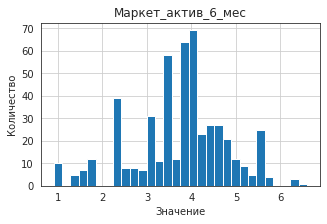

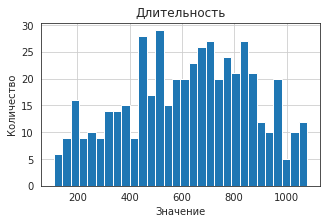

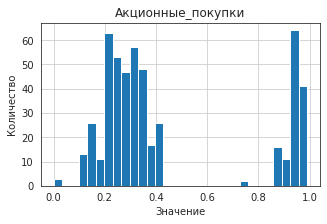

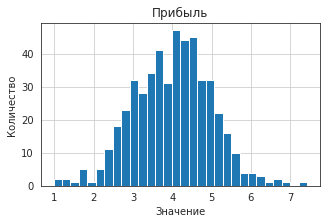

In [48]:
print('Распределение непрерывных количественных признаков среди покупателей со сниженной активностью')
for column in df_main_interval_cols:
    df_main_down[column].hist(figsize=(5,3),bins=30)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();

Распределение дискретных количественных признаков среди покупателей со сниженной активностью


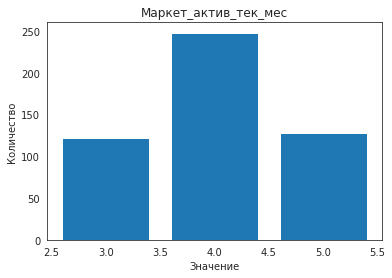

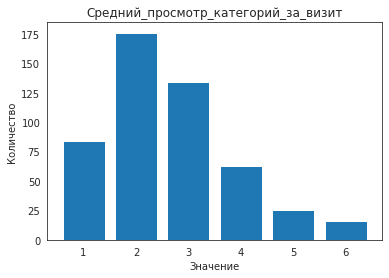

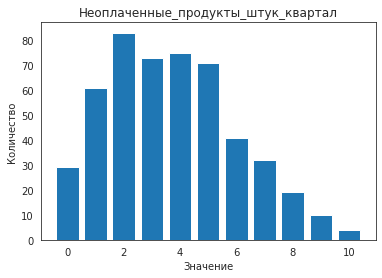

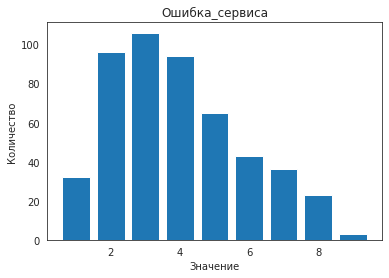

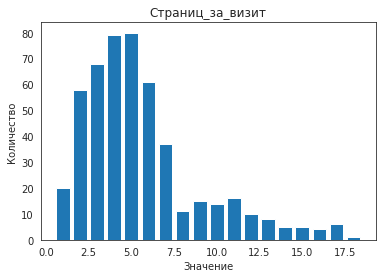

In [49]:
print('Распределение дискретных количественных признаков среди покупателей со сниженной активностью')
for column in df_main_diskret_cols:
    plt.bar(df_main_down[column].value_counts().index, df_main_down[column].value_counts().values)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();

Распределение непрерывных количественных признаков среди покупателей с прежней активностью


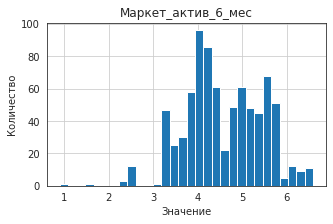

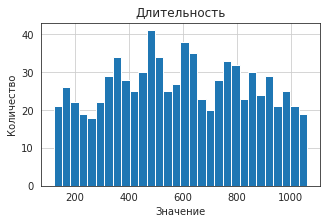

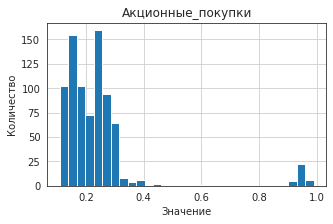

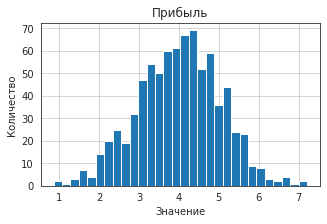

In [50]:
print('Распределение непрерывных количественных признаков среди покупателей с прежней активностью')
for column in df_main_interval_cols:
    df_main_same[column].hist(figsize=(5,3),bins=30)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();

Распределение дискретных количественных признаков среди покупателей с прежней активностью


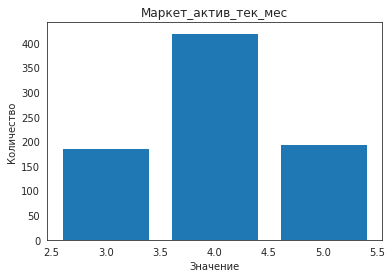

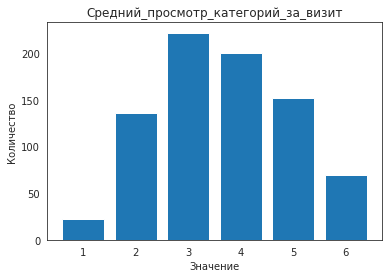

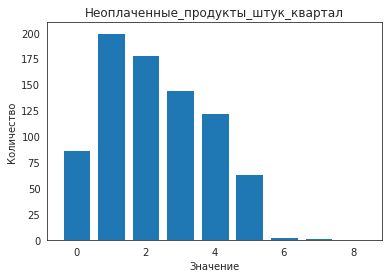

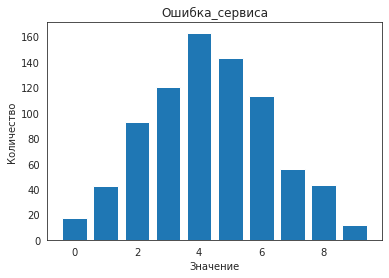

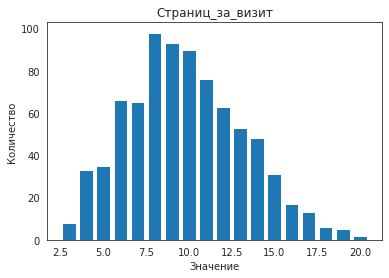

In [51]:
print('Распределение дискретных количественных признаков среди покупателей с прежней активностью')
for column in df_main_diskret_cols:
    plt.bar(df_main_same[column].value_counts().index, df_main_same[column].value_counts().values)
    plt.title(column)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show();

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Пожалуйста "доведи" график(и), так, чтобы эта похвала ниже стала заслуженной ))))   
    
---    
**Просто супер: график подписан, оси подписаны (проверь - так ли это в твоем случае?)**. Не часто на самом деле такой скрупулёзный подход к оформлению встречается. Молодец! Также, здорово, что есть объяснение поведения данного графика. Пытаться понять полученный результат - важная часть работы аналитика.
   
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поправил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>



Ряд признаков в наших данных имеет дискретную природу (например это: 'Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', ... (*не привожу все названия из данных*)). Для графического анализа дискретных признаков нужнен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать **sns.countplot** или **.plot(kind='bar')**. Ты же для визуализации их используешь гистограмму.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'>Поправил</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

Самым важным признаком для модели оказались прочитанные странницы за визит, у клиентов со сниженной активностью пик сдвинут в сторону более маленьких значений, что означает, что нам следует внедрить алгоритмы, которые будут держать внимание клиента и он бы не закрывал сайт, после пары просмотренных странниц

Основное распределение времени на сайте у пользователей со сниженной активностей в текущем и предыдущем периоде сдвинут в сторону более маленьких чисел. То же самое можно сказать о просмотре разных категорий и странниц за один визит. Также у людей со сниженной активностью есть пик в единице на признаке доли акционных покупок.

На основе вышесказанного можно утверждать, что сайту требуется улучшить свои системы рекомендаций, чтоды удерживать целевую аудиторию, чтобы учеличить время проведенное на сайте и количество странниц. Также, мы видим, что в акциях наиболее заинтересованна аудитория со сниженной активностью, возможно стоит увеличить количество предлагаемых акций и разработать модель по целесообразности выдавания тому или иному клиенту акции на интересующую его категорию, так как мы не хотим выдавать  акции всем, так как это может привести к потере аудитории

# Шаг 9. Итоговый вывод

На первом шагу мы считали данные, данные считались нормально, почти все признаки имели тот тип данных, который нужно(кроме одного)

На втором шагу выполнялась предобработка данных. В четвертой таблицы с прибылью продавца требовалось сменить данных на числовой с плавающей запятой. Далее данные были проверены на пропуски и явные и неявные дубликаты. Нашлось только немного неявных дубликатах, которые мы исправили

Третий шаг это исследовательский анализ данных. На этом этапе мы ждя всех количественных признаков построили диаграммы размаха и на основе их избавились от выбросов, далее построили гистрограммы и проанализировали распределения, которые в основном были нормальные, за парой исключений, например акционные покупки, которые также имели пик в единице.

Четвертый шаг это объединение таблиц. На данном этапе нам требовалось соединить три таблицы(основная таблица с поведением покупателя, таблица с выручкой с покупателя, таблица с временм проведенном на сайте для каждого покупателя), под каждый период была сделана отдельная колонка.

Пятый шаг это корреляционный анализ, была построена матрица корреляций Фика и по итогу анализа, мы пришли к выводу, что мультиколинеарности не выявлено

На шестом шаге мы написали пайплайн и выбрали наиболее точную модель и методы обработки данных. Была выбрана модель SVC с ядром rbf и скейлером RobustScaler

На седьмом этапе был проведен анализ важности признаков, наиболее значимыми были выделены: просмотр странниц, доли акционных покупок и выручка за препредыдущий месяц, также некоторые признаки получили отрицательную важность.

На восьмом шаге мы выбрали сегмент со сниженной активностью среди клиентов и сравнили их с клиентами, которые не сбавляли своё взаимодействие с сайтом, пришли к выводу, что требуется развить алгоритмы рекомендаций и выдаче акций клиентам для удержания аудитории

# Результат ревью:

Я отмечаю адекватный уровень твоей программистской подготовки. Ты используешь продвинутые концепции языка Python, библиотеки pandas и одной из основных библиотек машинного обучения sckit-learn. Всё это в целом упрощает твой код и одновременно показывает твой уровень владения инструментами анализа данных и machine learning.

С комментированием никаких проблем нет. Твоих объяснений достаточно для понимания твоими коллегами хода мыслей. Ссылки из брифа проекта в нужных местах также помогают следовать за развитием событий и дают полную информацию касаемо того, что будет происходить в том или ином разделе проекта.

Мне было просто проверять твой проект, потому что он чётко структурирован, с использованием оглавления. 

Зелёным цветом я отметил и прокомментировал удачные и элегантные решения, на которые ты можешь опираться в будущих проектах.

Жёлтым цветом я выделил то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас.

Однако есть принципиальные моменты, которые не позволяют мне принять твой проект в его нынешнем состоянии:

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b> 
    
1. (16) Баг в данных не найден.
    
2. (21) Тебе для анализа дали реальные данные реальной активности реальных покупателей. Ты "пригладил эти данные горячим утюгом", сделал из реальных - некую "среднюю картину". После того как твоя модель пойдёт в продакшн - она будет плохо работать на реальных данных.    
    
3. (22, 58) Следует соблюдать правила оформления графиков.     
    
4. (22, 58) Ряд признаков в наших данных имеет дискретную природу (например это: 'Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', ... (*не привожу все названия из данных*)). Для графического анализа дискретных признаков нужнен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать **sns.countplot** или **.plot(kind='bar')**. Ты же для визуализации их используешь гистограмму.
    
5. (22 и ниже, во многих местах) Сколько в наших данных признаков с нормальным распределением? Следует выполнить подобную "строгую" проверку (с использованием статистического теста). В любом случае голословное (БЕЗ проверки) утверждение "о нормальности" - это не до конца выполненное аналитиком данных исследование.

6. (39) Все ли признаки в interval_cols сейчас действительно непрерывные? Или "затесались" в список ещё и дискретные?        
    
7. (42) Стоит настроить работу энкодера OneHotEncoder на работу с неизвестными значениями признаков - сейчас энкодер "при встрече с неизвестной категорией" (это может случиться в проде) - будет выбрасывать ошибку.    
    
8. (46) Почему метрика поменялась на roc_auc? Выше ты говорил о precision.    

9. (46) А зачем нам в проекте нужна была тестовая выборка? Почему она в этом разделе нигде не появилась и нигде не была использована?    
    
10. (48, 49) Что и зачем происходит в этой ячейке?

</div>

Эти моменты требуют твоего внимания. Комментарии по ним помечены красным цветом. 

Подводя итог: хорошая работа на самом-то деле, молодец! Есть несколько моментов к исправлению, но уверен, что они не вызовут у тебя сложностей. После доработки обязательно проверь комментарии и выводы. Их нужно будет скорректировать. Жду доработанную версию проекта на повторное ревью.